# Importing all the important libraries

In [1]:
import os
import re
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
from utils.gpu import get_device
from utils.dataframe import (
    save_gen_df, append_gen_df, save_spt_df, load_gen_df, load_spt_df
)
from tqdm.notebook import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
import unicodedata
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, SeamlessM4TForTextToText, AutoProcessor
from sentence_transformers import SentenceTransformer, util
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# Common

In [ ]:
# get device
device = get_device()

# Functions

In [9]:
# Function to normalize text
def normalize_text(text):
    if pd.isnull(text):
        return text  # Skip null values
    # Apply Unicode normalization
    normalized_text = unicodedata.normalize('NFC', text)
    # Convert to lowercase
    normalized_text = normalized_text.lower()
    # Standardize punctuation (e.g., replace unusual punctuation marks)
    normalized_text = normalized_text.replace('“', '"').replace('”', '"').replace('’', "'")
    return normalized_text

In [10]:
# Function to normalize Burmese text (handles diacritical marks and stacked consonants)
def normalize_burmese(text):
    if pd.isnull(text):
        return text  # Skip null values
    normalized_text = unicodedata.normalize('NFKC', text)
    # Additional Burmese-specific normalization can be added here if needed
    return normalized_text

In [11]:
# Enhanced function to detect excessive word or substring repetitions
def has_repeated_words_for_burmese(text, min_repeats=3):
    if not isinstance(text, str):
        return False

    # Match repeated words (ensures it does not match sequences of digits or characters)
    repeated_pattern = re.compile(rf'(\S{{2,}})(?:\s?\1){{{min_repeats - 1},}}')
    return bool(repeated_pattern.search(text))

# Set settings

In [12]:
tqdm.pandas()

# 1. Dataset Loading

This step involves loading the datasets `myXNLI` and `ALT Corpus` into pandas DataFrames. 
The English and Burmese datasets from the ALT Corpus are combined to create a bilingual parallel corpus.

## myXNLI

In [13]:
# Load myXNLI dataset
myxnli_path = './data/myXNLI.train.tsv'  # Path to the file
myxnli_data = pd.read_csv(myxnli_path, sep='\t', header=0)
print(f"myXNLI dataset loaded successfully with {len(myxnli_data)} records.")
display(myxnli_data.head())  # Display the first few rows of the dataset

myXNLI dataset loaded successfully with 392702 records.


,genre,label,sentence1_en,sentence2_en,sentence1_my,sentence2_my
0,government,neutral,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,သဘောတရားအရ ခရင်မ်စိမ်ခြင်းတွင် အခြေခံအတိုင်းအတ...,ထုတ်ကုန်နှင့် ပထဝီဝင်အနေအထားသည် ခရင်မ် skimmin...
1,telephone,entailment,you know during the season and i guess at at y...,You lose the things to the following level if ...,ရာသီအတွင်း မင်းသိတယ်၊ မင်းရဲ့အဆင့်ကို ငါ ခန့်မ...,လူတွေပြန်ခေါ်ရင် အောက်ပါအဆင့်အထိ ဆုံးရှုံးသွား...
2,fiction,entailment,One of our number will carry out your instruct...,A member of my team will execute your orders w...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,ကျွန်ုပ်၏အဖွဲ့သားတစ်ဦးသည် သင်၏အမိန့်စာများကို ...
3,fiction,entailment,How do you know? All this is their information...,This information belongs to them.,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,ဒီအချက်အလက်က သူတို့ပိုင်တယ်။
4,telephone,neutral,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,ဟုတ်တယ် ငါမင်းကိုပြောပြမယ် ဒီတင်းနစ်ဖိနပ်တချို...,တင်းနစ်ဖိနပ်များသည် ဈေးနှုန်းအမျိုးမျိုးရှိသည်။


In [14]:
# split sentence 1 and sentence 2
myxnli_1 = myxnli_data[["sentence1_en", "sentence1_my"]]
myxnli_1.columns = ["english", "burmese"]

myxnli_2 = myxnli_data[["sentence2_en", "sentence2_my"]]
myxnli_2.columns = ["english", "burmese"]

## ALT

In [15]:
# Load ALT English data
alt_en_path = './data/ALT_data_en.txt'  # Path to the English ALT corpus
alt_en_lines = []  # List to store the lines of the English ALT corpus
with open(alt_en_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        columns = line.split('\t')
        if len(columns) == 2:
            alt_en_lines.append({
                "id": columns[0],
                "english": columns[1]
            })
print(f"ALT English dataset loaded successfully with {len(alt_en_lines)} records.")

ALT English dataset loaded successfully with 20106 records.


In [16]:
# convert the list to a DataFrame
alt_en_data = pd.DataFrame(alt_en_lines)
print(f"ALT English dataset loaded successfully with {len(alt_en_data)} records.")
display(alt_en_data.head())

ALT English dataset loaded successfully with 20106 records.


,id,english
0,SNT.80188.1,Italy have defeated Portugal 31-5 in Pool C of...
1,SNT.80188.2,Andrea Masi opened the scoring in the fourth m...
2,SNT.80188.3,Despite controlling the game for much of the f...
3,SNT.80188.4,Portugal never gave up and David Penalva score...
4,SNT.80188.5,Italy led 16-5 at half time but were matched b...


In [17]:
# Load ALT burmese data
alt_my_path = './data/ALT_data_my.txt'  # Path to the Burmese ALT corpus
alt_my_lines = []  # List to store the lines of the Burmese ALT corpus
with open(alt_my_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        columns = line.split('\t')
        if len(columns) == 2:
            alt_my_lines.append({
                "id": columns[0],
                "burmese": columns[1]
            })
print(f"ALT Burmese dataset loaded successfully with {len(alt_my_lines)} records.")

ALT Burmese dataset loaded successfully with 20106 records.


In [18]:
# convert the list to a DataFrame
alt_my_data = pd.DataFrame(alt_my_lines)
print(f"ALT Burmese dataset loaded successfully with {len(alt_my_data)} records.")
display(alt_my_data.head())

ALT Burmese dataset loaded successfully with 20106 records.


,id,burmese
0,SNT.80188.1,ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂...
1,SNT.80188.2,အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...
2,SNT.80188.3,ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကိ...
3,SNT.80188.4,ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...
4,SNT.80188.5,အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...


In [19]:
# Combine ALT datasets (if IDs match)
alt_combined = pd.merge(alt_en_data, alt_my_data, on="id")
print(f"ALT combined dataset created successfully with {len(alt_combined)} records.")
display(alt_combined.head())

ALT combined dataset created successfully with 20106 records.


,id,english,burmese
0,SNT.80188.1,Italy have defeated Portugal 31-5 in Pool C of...,ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂...
1,SNT.80188.2,Andrea Masi opened the scoring in the fourth m...,အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...
2,SNT.80188.3,Despite controlling the game for much of the f...,ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကိ...
3,SNT.80188.4,Portugal never gave up and David Penalva score...,ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...
4,SNT.80188.5,Italy led 16-5 at half time but were matched b...,အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...


# 2. Data Cleaning
This step focuses on cleaning the datasets to prepare them for further processing. The cleaning operations include:
1. Removing duplicate entries.
2. Handling missing values.
3. Removing non-standard characters or symbols unrelated to the Burmese or English language.
4. Ensuring consistent formatting.

The cleaned datasets will be ready for normalization and tokenization in the next steps.

## myXNLI

### Sentence 1

In [ ]:
# Cleaning myXNLI sentence 1
print("Cleaning myXNLI sentence 1 dataset...")
myxnli_cleaned_1 = myxnli_1.copy()
myxnli_cleaned_1 = myxnli_cleaned_1.drop_duplicates()  # Remove duplicates
myxnli_cleaned_1 = myxnli_cleaned_1.dropna()  # Remove rows with missing values
print(f"myXNLI sentence 1 dataset cleaned successfully.")
print(f"Original Records: {len(myxnli_1)}.")
print(f"Remaining records: {len(myxnli_cleaned_1)}.")
display(myxnli_cleaned_1.head())

Cleaning myXNLI sentence 1 dataset...
myXNLI sentence 1 dataset cleaned successfully.
Original Records: 392702.
Remaining records: 142954.


,english,burmese
0,Conceptually cream skimming has two basic dime...,သဘောတရားအရ ခရင်မ်စိမ်ခြင်းတွင် အခြေခံအတိုင်းအတ...
1,you know during the season and i guess at at y...,ရာသီအတွင်း မင်းသိတယ်၊ မင်းရဲ့အဆင့်ကို ငါ ခန့်မ...
2,One of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...
3,How do you know? All this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...
4,yeah i tell you what though if you go price so...,ဟုတ်တယ် ငါမင်းကိုပြောပြမယ် ဒီတင်းနစ်ဖိနပ်တချို...


In [70]:
# save cleaned myXNLI sentence 1 dataset
save_gen_df(myxnli_cleaned_1, "myxnli_cleaned_1")

### Sentence 2

In [ ]:
# Cleaning myXNLI sentence 2
print("Cleaning myXNLI sentence 2 dataset...")
myxnli_cleaned_2 = myxnli_2.copy()
myxnli_cleaned_2 = myxnli_cleaned_2.drop_duplicates()  # Remove duplicates
myxnli_cleaned_2 = myxnli_cleaned_2.dropna()  # Remove rows with missing values
print(f"myXNLI sentence 2 dataset cleaned successfully.")
print(f"Original Records: {len(myxnli_2)}.")
print(f"Remaining records: {len(myxnli_cleaned_2)}.")
display(myxnli_cleaned_2.head())

Cleaning myXNLI sentence 2 dataset...
myXNLI sentence 2 dataset cleaned successfully.
Original Records: 392702.
Remaining records: 391514.


,english,burmese
0,Product and geography are what make cream skim...,ထုတ်ကုန်နှင့် ပထဝီဝင်အနေအထားသည် ခရင်မ် skimmin...
1,You lose the things to the following level if ...,လူတွေပြန်ခေါ်ရင် အောက်ပါအဆင့်အထိ ဆုံးရှုံးသွား...
2,A member of my team will execute your orders w...,ကျွန်ုပ်၏အဖွဲ့သားတစ်ဦးသည် သင်၏အမိန့်စာများကို ...
3,This information belongs to them.,ဒီအချက်အလက်က သူတို့ပိုင်တယ်။
4,The tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်များသည် ဈေးနှုန်းအမျိုးမျိုးရှိသည်။


In [72]:
# save cleaned myXNLI sentence 2 dataset
save_gen_df(myxnli_cleaned_2, "myxnli_cleaned_2")

## ALT

In [ ]:
# Cleaning ALT combined data
print("Cleaning ALT combined dataset...")
alt_combined_cleaned = alt_combined.copy()
alt_combined_cleaned = alt_combined_cleaned.drop_duplicates()  # Remove duplicates
alt_combined_cleaned = alt_combined_cleaned.dropna()  # Remove rows with missing values
print(f"ALT English dataset cleaned successfully.")
print(f"Original records: {len(alt_en_data)}.")
print(f"Remaining records: {len(alt_combined_cleaned)}.")
display(alt_combined_cleaned.head())

Cleaning ALT combined dataset...
ALT English dataset cleaned successfully.
Original records: 20106.
Remaining records: 20106.


,id,english,burmese
0,SNT.80188.1,Italy have defeated Portugal 31-5 in Pool C of...,ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂...
1,SNT.80188.2,Andrea Masi opened the scoring in the fourth m...,အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...
2,SNT.80188.3,Despite controlling the game for much of the f...,ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကိ...
3,SNT.80188.4,Portugal never gave up and David Penalva score...,ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...
4,SNT.80188.5,Italy led 16-5 at half time but were matched b...,အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...


In [74]:
# save cleaned combined ALT dataset
save_gen_df(alt_combined_cleaned, "alt_combined_cleaned")

# 3. Data Normalization
This step normalizes the text data to ensure consistency across datasets. The normalization process includes:
1. Applying Unicode normalization to handle encoding inconsistencies.
2. Standardizing text formatting by converting all text to lowercase and standardizing punctuation.
3. Normalizing diacritical marks and stacked consonants in the Burmese text to improve text representation.

## myXNLI

### Sentence 1

In [ ]:
# Normalize myXNLI sentence 1 cleaned dataset
print("Normalizing myXNLI sentence 1 dataset...")
myxnli_normalized_1 = load_gen_df("myxnli_cleaned_1")

# Normalize English columns
myxnli_normalized_1["english"] = myxnli_normalized_1["english"].apply(normalize_text)

# Normalize Burmese columns
myxnli_normalized_1["burmese"] = myxnli_normalized_1["burmese"].apply(normalize_burmese)

print(f"myXNLI sentence 1 dataset normalized successfully.")
display(myxnli_normalized_1.head())

Normalizing myXNLI sentence 1 dataset...
myXNLI sentence 1 dataset normalized successfully.


,english,burmese
0,conceptually cream skimming has two basic dime...,သဘောတရားအရ ခရင်မ်စိမ်ခြင်းတွင် အခြေခံအတိုင်းအတ...
1,you know during the season and i guess at at y...,ရာသီအတွင်း မင်းသိတယ်၊ မင်းရဲ့အဆင့်ကို ငါ ခန့်မ...
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...
4,yeah i tell you what though if you go price so...,ဟုတ်တယ် ငါမင်းကိုပြောပြမယ် ဒီတင်းနစ်ဖိနပ်တချို...


Remove duplicate rows to ensure data consistency and cleanliness.

In [ ]:
# remove duplicates
print(f"Original Records: {len(myxnli_normalized_1)}.")
myxnli_normalized_1 = myxnli_normalized_1.drop_duplicates()
print(f"Remaining records: {len(myxnli_normalized_1)}.")

Original Records: 142954.
Remaining records: 142951.


In [77]:
# save normalized myXNLI sentence 1 dataset
save_gen_df(myxnli_normalized_1, "myxnli_normalized_1")

### Sentence 2

In [ ]:
# Normalize myXNLI sentence 2 cleaned dataset
print("Normalizing myXNLI sentence 2 dataset...")
myxnli_normalized_2 = load_gen_df("myxnli_cleaned_2")

# Normalize English columns
myxnli_normalized_2["english"] = myxnli_normalized_2["english"].apply(normalize_text)

# Normalize Burmese columns
myxnli_normalized_2["burmese"] = myxnli_normalized_2["burmese"].apply(normalize_burmese)

print(f"myXNLI sentence 2 dataset normalized successfully.")
display(myxnli_normalized_2.head())

Normalizing myXNLI sentence 2 dataset...
myXNLI sentence 2 dataset normalized successfully.


,english,burmese
0,product and geography are what make cream skim...,ထုတ်ကုန်နှင့် ပထဝီဝင်အနေအထားသည် ခရင်မ် skimmin...
1,you lose the things to the following level if ...,လူတွေပြန်ခေါ်ရင် အောက်ပါအဆင့်အထိ ဆုံးရှုံးသွား...
2,a member of my team will execute your orders w...,ကျွန်ုပ်၏အဖွဲ့သားတစ်ဦးသည် သင်၏အမိန့်စာများကို ...
3,this information belongs to them.,ဒီအချက်အလက်က သူတို့ပိုင်တယ်။
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်များသည် ဈေးနှုန်းအမျိုးမျိုးရှိသည်။


Remove duplicate rows to ensure data consistency and cleanliness.

In [ ]:
# remove duplicates
print(f"Original Records: {len(myxnli_normalized_2)}.")
myxnli_normalized_2 = myxnli_normalized_2.drop_duplicates()
print(f"Remaining records: {len(myxnli_normalized_2)}.")

Original Records: 391514.
Remaining records: 391504.


In [80]:
# save normalized myXNLI sentence 2 dataset
save_gen_df(myxnli_normalized_2, "myxnli_normalized_2")

## ALT

In [ ]:
# Normalize combined ALT cleaned dataset
print("Normalizing combined ALT dataset...")
alt_combined_normalized = load_gen_df("alt_combined_cleaned")
alt_combined_normalized["english"] = alt_combined_normalized["english"].apply(normalize_text)
alt_combined_normalized["burmese"] = alt_combined_normalized["burmese"].apply(normalize_burmese)
print(f"Combined ALT dataset normalized successfully.")
display(alt_combined_normalized.head())

Normalizing combined ALT dataset...
Combined ALT dataset normalized successfully.


,id,english,burmese
0,SNT.80188.1,italy have defeated portugal 31-5 in pool c of...,ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂...
1,SNT.80188.2,andrea masi opened the scoring in the fourth m...,အန်ဒရီယာ မာစီ သည် အီတလီ အတွက် စမ်းသပ်မှု တစ်ခု...
2,SNT.80188.3,despite controlling the game for much of the f...,ပထမ တစ်ဝက် ၏ တော်တော်များများ အတွက် ကစားပွဲ ကိ...
3,SNT.80188.4,portugal never gave up and david penalva score...,ပေါ်တူဂီ သည် ဘယ်သောအခါမှ စွန့်လွှတ်မှု မရှိခဲ့...
4,SNT.80188.5,italy led 16-5 at half time but were matched b...,အီတလီ သည် ပထမပိုင်း ၌ ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့ သေ...


Remove duplicate rows to ensure data consistency and cleanliness.

In [ ]:
# remove duplicates
print(f"Original Records: {len(alt_combined_normalized)}.")
alt_combined_normalized = alt_combined_normalized.drop_duplicates()
print(f"Remaining records: {len(alt_combined_normalized)}.")

Original Records: 20106.
Remaining records: 20106.


In [83]:
# save normalized ALT dataset
save_gen_df(alt_combined_normalized, "alt_combined_normalized")

# 4. Back-Translation Augmentation
This step applies back-translation augmentation to the `myXNLI` and `ALT Combined` datasets. Models (`facebook/nllb-200-distilled-600M` and `facebook/hf-seamless-m4t-large`) are used to generate synthetic data. 
Results are stored in additional columns for evaluation and comparison.

In [84]:
# load normalized myXNLI and Combined ALT  dataset
myxnli_back_translate_1 = load_gen_df("myxnli_normalized_1")
myxnli_back_translate_2 = load_gen_df("myxnli_normalized_2")
alt_combined_back_translate = load_gen_df("alt_combined_normalized")

In [85]:
# Custom Dataset class for loading sentences
class SentenceDataset(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx]

## facebook/nllb-200-distilled-600M

In [86]:
# Load NLLB model and tokenizer
nllb_model_name = "facebook/nllb-200-distilled-600M"
nllb_model = AutoModelForSeq2SeqLM.from_pretrained(nllb_model_name).to(device)
nllb_tokenizer = AutoTokenizer.from_pretrained(nllb_model_name)

In [87]:
# Function for back-translation using NLLB
def back_translate_nllb_batch(batch, src_lang="eng_Latn", tgt_lang="mya_Mymr"):
    try:
        # Forward translation: English -> Burmese
        inputs = nllb_tokenizer(batch, return_tensors="pt", truncation=True, padding=True).to(device)
        translated_tokens = nllb_model.generate(
            **inputs, forced_bos_token_id=nllb_tokenizer.convert_tokens_to_ids(tgt_lang)
        )
        translated_texts = nllb_tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        
        # Backward translation: Burmese -> English
        back_inputs = nllb_tokenizer(translated_texts, return_tensors="pt", truncation=True, padding=True).to(device)
        back_translated_tokens = nllb_model.generate(
            **back_inputs, forced_bos_token_id=nllb_tokenizer.convert_tokens_to_ids(src_lang)
        )
        back_translated_texts = nllb_tokenizer.batch_decode(back_translated_tokens, skip_special_tokens=True)
        
        return translated_texts, back_translated_texts
    except Exception as e:
        print(f"Error processing batch. Error: {e}")
        return [None] * len(batch), [None] * len(batch)

In [88]:
nllb_batch_size = 50

### myXNLI dataset

#### Sentence 1

In [89]:
# Dataset and DataLoader for sentence 1
myxnli_nllb_back_translate_sentences_1 = myxnli_back_translate_1["english"].tolist()
myxnli_nllb_back_translate_dataset_1 = SentenceDataset(myxnli_nllb_back_translate_sentences_1)
myxnli_nllb_back_translate_dataloader_1 = DataLoader(myxnli_nllb_back_translate_dataset_1, batch_size=nllb_batch_size, shuffle=False)

In [ ]:
# Apply back-translation to the sentences 1 in myXNLI
print("Applying back-translation to myXNLI dataset (sentences 1)...")
for batch_idx, batch in enumerate(tqdm(myxnli_nllb_back_translate_dataloader_1, desc="Processing batches")):
    try:
        # Perform back-translation
        translated_texts, back_translated_texts = back_translate_nllb_batch(batch)
        
        # Collect results for this batch
        batch_results = []
        for original, translated, back_translated in zip(batch, translated_texts, back_translated_texts):
            # Add to results list
            batch_results.append({
                "english_original": original,
                "burmese_translated": translated,
                "english_back_translated": back_translated,
            })
        
        # Convert batch results to DataFrame and save incrementally
        batch_df = pd.DataFrame(batch_results)
        if batch_idx == 0:
            # Save with header for the first batch
            save_gen_df(batch_df, "myxnli_nllb_back_translated_1")
        else:
            # Append without header for subsequent batches
            append_gen_df(batch_df, "myxnli_nllb_back_translated_1")

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

print("Back-translation completed.")

##### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [22]:
# load myxnli sentence 1 back translated dataset
myxnli_nllb_back_translated_1 = load_gen_df("myxnli_nllb_back_translated_1")
print(f"Records: {len(myxnli_nllb_back_translated_1)}")
display(myxnli_nllb_back_translated_1.head())

Records: 142951


,english_original,burmese_translated,english_back_translated
0,conceptually cream skimming has two basic dime...,စိတ်ကူးအရ ခရမ်းချဉ်ခြင်းမှာ အခြေခံအတိုင်းအတာ န...,The idea is that there are two basic dimension...
1,you know during the season and i guess at at y...,ရာသီအတွင်းမှာ သိတယ်ထင်တယ် သင့်အဆင့်မှာ ခင်ဗျား...,"During the season, I think you know, at your l..."
2,one of our number will carry out your instruct...,ကျွန်တော်တို့ရဲ့ အဖွဲ့ဝင်တစ်ယောက်က ခင်ဗျားရဲ့ ...,One of our members will follow your instructio...
3,how do you know? all this is their information...,ဒါအားလုံးက သူတို့သတင်းတွေပဲလေ။,It's all their news.
4,yeah i tell you what though if you go price so...,ဟုတ်ကဲ့ ကျွန်တော်ပြောပြပါရစေ သင်သွားရင် တန်ဖို...,"Yeah, I'll tell you what, if you go and you're..."


In [23]:
# Check for null values in each column
myxnli_nllb_back_translated_1_rows_with_nulls = myxnli_nllb_back_translated_1[myxnli_nllb_back_translated_1.isnull().any(axis=1)]
print(f"Rows with null values: {len(myxnli_nllb_back_translated_1_rows_with_nulls)}")
display(myxnli_nllb_back_translated_1_rows_with_nulls)

Rows with null values: 2


,english_original,burmese_translated,english_back_translated
45964,program evaluation at,NaN,The first
119589,what are the actual or estimated dates for the,NaN,The first


In [24]:
# Display all duplicated rows
myxnli_nllb_back_translated_1_duplicated_rows = myxnli_nllb_back_translated_1[myxnli_nllb_back_translated_1.duplicated()]
print(f"Duplicated rows: {len(myxnli_nllb_back_translated_1_duplicated_rows)}")
display(myxnli_nllb_back_translated_1_duplicated_rows)

Duplicated rows: 14830


,english_original,burmese_translated,english_back_translated
55605,certainly.,သေချာပါတယ်။,I'm sure of it.
66039,self-contradiction,မိမိကိုယ်ကို ဆန့်ကျင်မှု,Against the self
66645,"as an independent regulatory agency, the commi...",လွတ်လပ်တဲ့ စည်းကမ်းရေး အဖွဲ့အစည်းတစ်ခုအနေနဲ့ က...,"As an independent regulatory body, the Commiss..."
75847,evaluation of limitations on total sulfur diox...,၂၀၁၈ ခုနှစ်မှ စတင်၍ စုစုပေါင်း ဆူပါဒိုင်အောက်ဆ...,"Since 2018, the assessment of the total superd..."
78612,what did he think?,သူဘာတွေးခဲ့လဲ။,What was he thinking?
...,...,...,...
142946,"some city delivery routes, called curb line ro...",မြို့ပြပို့ဆောင်ရေးလမ်းကြောင်းအချို့ကို ဘားဘီလ...,Some urban transport routes are called railway...
142947,democrats persuasively called livingston's res...,ဒီမိုကရက်တွေက Livingston ရဲ့ နုတ်ထွက်မှုကို တိ...,Democrats credibly called Livingston's resigna...
142948,the river canche flows right through the cente...,ဒီမြို့လေးရဲ့ အလယ်မှာ မြစ်က စီးဆင်းနေပြီး အဆော...,"In the middle of this small town, a river flow..."
142949,dolly parton's breast implants against mark mc...,Dolly Parton ရဲ့ ရင်သားအတုတွေကို Mark McGwire ...,Dolly Parton's breast implants are opposed to ...


In [25]:
# clean myxnli sentence 1 back translated dataset
print("Cleaning myxnli sentence 1 back translated dataset...")
myxnli_nllb_back_translated_cleaned_1 = myxnli_nllb_back_translated_1.copy()
myxnli_nllb_back_translated_cleaned_1 = myxnli_nllb_back_translated_cleaned_1.drop_duplicates()  # Remove duplicates
myxnli_nllb_back_translated_cleaned_1 = myxnli_nllb_back_translated_cleaned_1.dropna(subset=['burmese_translated', 'english_back_translated'])  # Remove rows with missing values
print(f"myXNLI sentence 1 back translated dataset cleaned successfully.")
print(f"Original records: {len(myxnli_nllb_back_translated_1)}")
print(f"Remaining records: {len(myxnli_nllb_back_translated_cleaned_1)}")
display(myxnli_nllb_back_translated_cleaned_1.head())

Cleaning myxnli sentence 1 back translated dataset...
myXNLI sentence 1 back translated dataset cleaned successfully.
Original records: 142951
Remaining records: 128119


,english_original,burmese_translated,english_back_translated
0,conceptually cream skimming has two basic dime...,စိတ်ကူးအရ ခရမ်းချဉ်ခြင်းမှာ အခြေခံအတိုင်းအတာ န...,The idea is that there are two basic dimension...
1,you know during the season and i guess at at y...,ရာသီအတွင်းမှာ သိတယ်ထင်တယ် သင့်အဆင့်မှာ ခင်ဗျား...,"During the season, I think you know, at your l..."
2,one of our number will carry out your instruct...,ကျွန်တော်တို့ရဲ့ အဖွဲ့ဝင်တစ်ယောက်က ခင်ဗျားရဲ့ ...,One of our members will follow your instructio...
3,how do you know? all this is their information...,ဒါအားလုံးက သူတို့သတင်းတွေပဲလေ။,It's all their news.
4,yeah i tell you what though if you go price so...,ဟုတ်ကဲ့ ကျွန်တော်ပြောပြပါရစေ သင်သွားရင် တန်ဖို...,"Yeah, I'll tell you what, if you go and you're..."


In [26]:
# Normalize myxnli sentence 1 back translated cleaned dataset
print("Normalizing myxnli sentence 1 back translated cleaned dataset...")
myxnli_nllb_back_translated_cleaned_1["english_back_translated"] = myxnli_nllb_back_translated_cleaned_1["english_back_translated"].apply(normalize_text)
myxnli_nllb_back_translated_cleaned_1["burmese_translated"] = myxnli_nllb_back_translated_cleaned_1["burmese_translated"].apply(normalize_burmese)
print(f"myxnli sentence 1 back translated cleaned dataset normalized successfully.")
display(myxnli_nllb_back_translated_cleaned_1.head())

Normalizing myxnli sentence 1 back translated cleaned dataset...
myxnli sentence 1 back translated cleaned dataset normalized successfully.


,english_original,burmese_translated,english_back_translated
0,conceptually cream skimming has two basic dime...,စိတ်ကူးအရ ခရမ်းချဉ်ခြင်းမှာ အခြေခံအတိုင်းအတာ န...,the idea is that there are two basic dimension...
1,you know during the season and i guess at at y...,ရာသီအတွင်းမှာ သိတယ်ထင်တယ် သင့်အဆင့်မှာ ခင်ဗျား...,"during the season, i think you know, at your l..."
2,one of our number will carry out your instruct...,ကျွန်တော်တို့ရဲ့ အဖွဲ့ဝင်တစ်ယောက်က ခင်ဗျားရဲ့ ...,one of our members will follow your instructio...
3,how do you know? all this is their information...,ဒါအားလုံးက သူတို့သတင်းတွေပဲလေ။,it's all their news.
4,yeah i tell you what though if you go price so...,ဟုတ်ကဲ့ ကျွန်တော်ပြောပြပါရစေ သင်သွားရင် တန်ဖို...,"yeah, i'll tell you what, if you go and you're..."


In [27]:
# Apply the repeated words detection to the Burmese translations
myxnli_nllb_back_translated_cleaned_1['has_repeated_words'] = myxnli_nllb_back_translated_cleaned_1['burmese_translated'].apply(
    lambda x: has_repeated_words_for_burmese(x, min_repeats=4)
)

In [28]:
# Extract rows with repeated words
myxnli_nllb_back_translated_repeated_1 = myxnli_nllb_back_translated_cleaned_1[myxnli_nllb_back_translated_cleaned_1['has_repeated_words']]
print(f"Found {len(myxnli_nllb_back_translated_repeated_1)} rows with repeated words.")
display(myxnli_nllb_back_translated_repeated_1)

Found 3759 rows with repeated words.


,english_original,burmese_translated,english_back_translated,has_repeated_words
30,"and in another shift in the economy, it was fo...",စီးပွားရေးမှာ နောက်တစ်ဆင့် ပြောင်းလဲမှုတစ်ခုမှ...,"in the next stage of economic change, the coun...",True
36,there's a uh a couple called um oh i'm going t...,အိုးအိုအိုအိုအိုအိုအိုအိုအိုအိုအိုအိုအိုအိုအို...,i'm not going to say anything about the future...,True
75,we stink all the time.,ကျွန်မတို့ဟာ အမြဲတမ်း မွှေးကြမ်းကြမ်းကြမ်းကြမ်...,we are always on the lookout for the best of t...,True
76,"in an increasingly interdependent world, many ...",တိုးတိုးတိုးတင့်တင့်တင့်တင့်တင့်တင့်တဲ့ ကမ္ဘာက...,"in a growing world, many of the pressing probl...",True
91,which i mean i think it should be anyway,ဆိုလိုတာက ဘာဖြစ်ဖြစ်ဖြစ်ဖြစ်ဖြစ်သင့်တယ်လို့ ထင...,"i mean, i think what happened should happen.",True
...,...,...,...,...
139795,"snorkel-fishing with spear-guns is legal, but ...",ပစ်ချည်တွေနဲ့ နှင်းလျှောငါးဖမ်းတာ တရားဝင်ပေမဲ့...,"the fishing of snow and ice is legal, but ofte...",True
140001,"a third group, not of different ethnic origin ...",တတိယအုပ်စုတစ်ခုမှာ ဂျပန်နိုင်ငံရဲ့ အဓိကစီးပွား...,a third group has a distinct ethnic origin fro...,True
140707,"the intervention, which lasted 30 to 40 minute...",အခန်းက အခန်းက အခန်းက အခန်းက အခန်းက အခန်းက အခန်...,room room room room room room room room room r...,True
141123,uh-huh yeah we're we're all for it our um we'v...,အိုးအိုးအိုးအိုးအိုးအိုးအိုးအိုးအိုးအိုးအိုးအိ...,ooh ooh ooh ooh ooh ooh ooh ooh ooh ooh ooh oo...,True


In [29]:
# save repeated words dataset
myxnli_nllb_back_translated_repeated_1 = myxnli_nllb_back_translated_repeated_1.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_nllb_back_translated_repeated_1, "myxnli_nllb_back_translated_repeated_1")

In [30]:
# Drop rows with repeated words
print(f"Original records: {len(myxnli_nllb_back_translated_cleaned_1)}.")
myxnli_nllb_back_translated_cleaned_1 = myxnli_nllb_back_translated_cleaned_1[~myxnli_nllb_back_translated_cleaned_1['has_repeated_words']]
print(f"Remaining records after removing rows with repeated words: {len(myxnli_nllb_back_translated_cleaned_1)}.")

Original records: 128119.
Remaining records after removing rows with repeated words: 124360.


In [31]:
# save cleaned and normalized myxnli sentence 1 back translated dataset
myxnli_nllb_back_translated_cleaned_1 = myxnli_nllb_back_translated_cleaned_1.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_nllb_back_translated_cleaned_1, "myxnli_nllb_back_translated_final_1")

#### Sentence 2

In [ ]:
# Dataset and DataLoader for sentence 2
myxnli_nllb_back_translate_sentences_2 = myxnli_back_translate_2["english"].tolist()
myxnli_nllb_back_translate_dataset_2 = SentenceDataset(myxnli_nllb_back_translate_sentences_2)
myxnli_nllb_back_translate_dataloader_2 = DataLoader(myxnli_nllb_back_translate_dataset_2, batch_size=nllb_batch_size, shuffle=False)

In [ ]:
# Apply back-translation to the sentences 2 in myXNLI
print("Applying back-translation to myXNLI dataset (sentences 2)...")
for batch_idx, batch in enumerate(tqdm(myxnli_nllb_back_translate_dataloader_2, desc="Processing batches")):
    try:
        # Perform back-translation
        translated_texts, back_translated_texts = back_translate_nllb_batch(batch)
        
        # Collect results for this batch
        batch_results = []
        for original, translated, back_translated in zip(batch, translated_texts, back_translated_texts):
            # Add to results list
            batch_results.append({
                "english_original": original,
                "burmese_translated": translated,
                "english_back_translated": back_translated,
            })
        
        # Convert batch results to DataFrame and save incrementally
        batch_df = pd.DataFrame(batch_results)
        if batch_idx == 0:
            # Save with header for the first batch
            save_gen_df(batch_df, "myxnli_nllb_back_translated_2")
        else:
            # Append without header for subsequent batches
            append_gen_df(batch_df, "myxnli_nllb_back_translated_2")

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

print("Back-translation completed.")

##### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [32]:
# load myxnli sentence 2 back translated dataset
myxnli_nllb_back_translated_2 = load_gen_df("myxnli_nllb_back_translated_2")
print(f"Records: {len(myxnli_nllb_back_translated_2)}")
display(myxnli_nllb_back_translated_2.head())

Records: 391504


,english_original,burmese_translated,english_back_translated
0,product and geography are what make cream skim...,ထုတ်ကုန်နဲ့ မြေပုံက ခရမ်းချဉ်ကို အလုပ်ဖြစ်အောင...,The product and the map make the cruise a real...
1,you lose the things to the following level if ...,လူတွေက သတိရရင် အရာတွေကို နောက်အဆင့်ကို ဆုံးရှု...,People lose things to the next level when they...
2,a member of my team will execute your orders w...,ကျွန်တော့အဖွဲ့ဝင်တစ်ယောက်က ခင်ဗျားရဲ့ အမိန့်တွ...,One of my team members will do your orders so ...
3,this information belongs to them.,ဒီသတင်းအချက်အလက်က သူတို့ဆီကပါ။,This information is from them.
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်တွေမှာ စျေးနှုန်း အမျိုးမျိုးရှိပါ...,There are different prices for tenny shoes.


In [33]:
# Check for null values in each column
myxnli_nllb_back_translated_2_rows_with_nulls = myxnli_nllb_back_translated_2[myxnli_nllb_back_translated_2.isnull().any(axis=1)]
print(f"Rows with null values: {len(myxnli_nllb_back_translated_2_rows_with_nulls)}")
display(myxnli_nllb_back_translated_2_rows_with_nulls)

Rows with null values: 0


,english_original,burmese_translated,english_back_translated


In [34]:
# Display all duplicated rows
myxnli_nllb_back_translated_2_duplicated_rows = myxnli_nllb_back_translated_2[myxnli_nllb_back_translated_2.duplicated()]
print(f"Duplicated rows: {len(myxnli_nllb_back_translated_2_duplicated_rows)}")
display(myxnli_nllb_back_translated_2_duplicated_rows)

Duplicated rows: 35


,english_original,burmese_translated,english_back_translated
21678,that's very good.,ဒါက အရမ်းကောင်းပါတယ်။,It's very good.
38099,not applicable,မချိုးပါ,I'm not touching you.
43774,that is what i think,ဒါက ကျွန်မ ထင်တာပါ,That's what I think.
109962,the state isn't involved at all.,နိုင်ငံတော်က လုံးဝ မပါဝင်ပါဘူး။,The state is not involved at all.
120447,that's not true.,အဲဒါ မမှန်ပါဘူး။,That's not true.
145397,i am unsure.,ကျွန်တော် မသေချာပါဘူး။,I'm not sure.
150212,the men walked away from each other.,အမျိုးသားတွေဟာ အချင်းချင်း ကွာသွားကြတယ်။,Men are going to see each other.
160626,that's terrible.,ဒါက ကြောက်စရာကြီးပါ။,This is scary.
181992,they don't know what they're doing.,သူတို့ ဘာလုပ်နေလဲ မသိကြဘူး။,They don't know what they're doing.
182143,that's bad.,ဒါက ဆိုးဝါးပါတယ်။,It's terrible.


In [35]:
# clean myxnli sentence 2 back translated dataset
print("Cleaning myxnli sentence 2 back translated dataset...")
myxnli_nllb_back_translated_cleaned_2 = myxnli_nllb_back_translated_2.copy()
myxnli_nllb_back_translated_cleaned_2 = myxnli_nllb_back_translated_cleaned_2.drop_duplicates()  # Remove duplicates
myxnli_nllb_back_translated_cleaned_2 = myxnli_nllb_back_translated_cleaned_2.dropna(subset=['burmese_translated', 'english_back_translated'])  # Remove rows with missing values
print(f"myXNLI sentence 2 back translated dataset cleaned successfully.")
print(f"Original records: {len(myxnli_nllb_back_translated_2)}")
print(f"Remaining records: {len(myxnli_nllb_back_translated_cleaned_2)}")
display(myxnli_nllb_back_translated_cleaned_2.head())

Cleaning myxnli sentence 2 back translated dataset...
myXNLI sentence 2 back translated dataset cleaned successfully.
Original records: 391504
Remaining records: 391469


,english_original,burmese_translated,english_back_translated
0,product and geography are what make cream skim...,ထုတ်ကုန်နဲ့ မြေပုံက ခရမ်းချဉ်ကို အလုပ်ဖြစ်အောင...,The product and the map make the cruise a real...
1,you lose the things to the following level if ...,လူတွေက သတိရရင် အရာတွေကို နောက်အဆင့်ကို ဆုံးရှု...,People lose things to the next level when they...
2,a member of my team will execute your orders w...,ကျွန်တော့အဖွဲ့ဝင်တစ်ယောက်က ခင်ဗျားရဲ့ အမိန့်တွ...,One of my team members will do your orders so ...
3,this information belongs to them.,ဒီသတင်းအချက်အလက်က သူတို့ဆီကပါ။,This information is from them.
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်တွေမှာ စျေးနှုန်း အမျိုးမျိုးရှိပါ...,There are different prices for tenny shoes.


In [36]:
# Normalize myxnli sentence 2 back translated cleaned dataset
print("Normalizing myxnli sentence 2 back translated cleaned dataset...")
myxnli_nllb_back_translated_cleaned_2["english_back_translated"] = myxnli_nllb_back_translated_cleaned_2["english_back_translated"].apply(normalize_text)
myxnli_nllb_back_translated_cleaned_2["burmese_translated"] = myxnli_nllb_back_translated_cleaned_2["burmese_translated"].apply(normalize_burmese)
print(f"myxnli sentence 2 back translated cleaned dataset normalized successfully.")
display(myxnli_nllb_back_translated_cleaned_2.head())

Normalizing myxnli sentence 2 back translated cleaned dataset...
myxnli sentence 2 back translated cleaned dataset normalized successfully.


,english_original,burmese_translated,english_back_translated
0,product and geography are what make cream skim...,ထုတ်ကုန်နဲ့ မြေပုံက ခရမ်းချဉ်ကို အလုပ်ဖြစ်အောင...,the product and the map make the cruise a real...
1,you lose the things to the following level if ...,လူတွေက သတိရရင် အရာတွေကို နောက်အဆင့်ကို ဆုံးရှု...,people lose things to the next level when they...
2,a member of my team will execute your orders w...,ကျွန်တော့အဖွဲ့ဝင်တစ်ယောက်က ခင်ဗျားရဲ့ အမိန့်တွ...,one of my team members will do your orders so ...
3,this information belongs to them.,ဒီသတင်းအချက်အလက်က သူတို့ဆီကပါ။,this information is from them.
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်တွေမှာ စျေးနှုန်း အမျိုးမျိုးရှိပါ...,there are different prices for tenny shoes.


In [37]:
# Apply the repeated words detection to the Burmese translations
myxnli_nllb_back_translated_cleaned_2['has_repeated_words'] = myxnli_nllb_back_translated_cleaned_2['burmese_translated'].apply(
    lambda x: has_repeated_words_for_burmese(x, min_repeats=4)
)

In [38]:
# Extract rows with repeated words
myxnli_nllb_back_translated_repeated_2 = myxnli_nllb_back_translated_cleaned_2[myxnli_nllb_back_translated_cleaned_2['has_repeated_words']]
print(f"Found {len(myxnli_nllb_back_translated_repeated_2)} rows with repeated words.")
display(myxnli_nllb_back_translated_repeated_2)

Found 1597 rows with repeated words.


,english_original,burmese_translated,english_back_translated,has_repeated_words
75,we always stink.,ကျွန်မတို့ အမြဲပဲ မွှေးကြမ်းကြမ်းကြမ်းကြမ်းကြမ...,we are always proud of our commitment to our m...,True
473,"mercury, nox, and so2 are best considered in h...","mercury, nox, and so2 တို့ဟာ ဘေးဖြစ်စေတဲ့ ဘေးဖ...","mercury, nox, and so2 are not included in the ...",True
739,treasury securities interest held by revolving...,ငွေလဲလှယ်နှုန်း ငွေလဲလှယ်နှုန်း ငွေလဲလှယ်နှုန်...,cash exchange rate cash exchange rate cash exc...,True
793,zelon was very intelligent,Zelon ဟာ တော်တော်တော်တော်တော်တော်တော်ပါ,zelon is a great leader.,True
1359,you won't find a friendlier group of people.,လူတွေရဲ့ ပိုမိုမိုမိုမိုမိုမိုမိုမိုမိုမိုမိုမ...,the people's more than a million people have b...,True
...,...,...,...,...
390041,the remark was so asinine that i didn't humor ...,အဲဒီ မှတ်ချက်ဟာ သိပ်ကို မိုက်လွန်းလို့ အဖြေနဲ့...,that note is so great that the answer and the ...,True
390138,there is no telling whether tomorrow will be b...,မနက်ဖြန်မှာ အပူပြင်းပြင်းပြင်းပြင်းပြင်းပြင်းပ...,tomorrow is hot hot hot hot hot hot hot hot ho...,True
390519,downtown aswan has a desert oasis that is wond...,Aswan မြို့လယ်မှာ သဲကန္တာရ သဲကန္တာရ သဲကန္တာရ သ...,"in the middle of aswan, there is a desert dese...",True
390758,the obese man smiled widely.,ဝတဲ့လူက ပြုံးပြုံးပြုံးပြုံးပြုံးပြုံးပြုံးပြု...,whoa whoa whoa whoa whoa whoa whoa whoa whoa w...,True


In [39]:
# save repeated words dataset
myxnli_nllb_back_translated_repeated_2 = myxnli_nllb_back_translated_repeated_2.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_nllb_back_translated_repeated_2, "myxnli_nllb_back_translated_repeated_2")

In [40]:
# Drop rows with repeated words
print(f"Original records: {len(myxnli_nllb_back_translated_cleaned_2)}.")
myxnli_nllb_back_translated_cleaned_2 = myxnli_nllb_back_translated_cleaned_2[~myxnli_nllb_back_translated_cleaned_2['has_repeated_words']]
print(f"Remaining records after removing rows with repeated words: {len(myxnli_nllb_back_translated_cleaned_2)}.")

Original records: 391469.
Remaining records after removing rows with repeated words: 389872.


In [41]:
# save cleaned and normalized myxnli sentence 1 back translated dataset
myxnli_nllb_back_translated_cleaned_2 = myxnli_nllb_back_translated_cleaned_2.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_nllb_back_translated_cleaned_2, "myxnli_nllb_back_translated_final_2")

### ALT dataset

In [ ]:
# Dataset and DataLoader
alt_combined_nllb_back_translate_sentences = alt_combined_back_translate["english"].tolist()
alt_combined_nllb_back_translate_dataset = SentenceDataset(alt_combined_nllb_back_translate_sentences)
alt_combined_nllb_back_translate_dataloader = DataLoader(alt_combined_nllb_back_translate_dataset, batch_size=nllb_batch_size, shuffle=False)

In [ ]:
# Apply back-translation to alt combined dataset
print("Applying back-translation to alt combined dataset...")
for batch_idx, batch in enumerate(tqdm(alt_combined_nllb_back_translate_dataloader, desc="Processing batches")):
    try:
        # Perform back-translation
        translated_texts, back_translated_texts = back_translate_nllb_batch(batch)
        
        # Collect results for this batch
        batch_results = []
        for original, translated, back_translated in zip(batch, translated_texts, back_translated_texts):
            # Add to results list
            batch_results.append({
                "english_original": original,
                "burmese_translated": translated,
                "english_back_translated": back_translated,
            })
        
        # Convert batch results to DataFrame and save incrementally
        batch_df = pd.DataFrame(batch_results)
        if batch_idx == 0:
            # Save with header for the first batch
            save_gen_df(batch_df, "alt_combined_nllb_back_translated")
        else:
            # Append without header for subsequent batches
            append_gen_df(batch_df, "alt_combined_nllb_back_translated")

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

print("Back-translation completed.")

##### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [42]:
# load alt combined back translated dataset
alt_combined_nllb_back_translated = load_gen_df("alt_combined_nllb_back_translated")
print(f"Records: {len(alt_combined_nllb_back_translated)}")
display(alt_combined_nllb_back_translated.head())

Records: 20106


,english_original,burmese_translated,english_back_translated
0,italy have defeated portugal 31-5 in pool c of...,အီတလီနိုင်ငံသည် ပြင်သစ်နိုင်ငံ ပါရီမြို့ရှိ Pa...,Italy defeated Portugal 31-5 in the 2007 Rugby...
1,andrea masi opened the scoring in the fourth m...,Andrea Masi က စတုတ္ထမိနစ်မှာ အီတလီအတွက် ကြိုးစ...,Andrea Masi scored a goal in the fourth minute...
2,despite controlling the game for much of the f...,ပထမပိုင်းအများစုကို ကစားပွဲကို ထိန်းချုပ်ထားပေ...,Although the first half of the game was contro...
3,portugal never gave up and david penalva score...,ပေါ်တူဂီအသင်းက ဘယ်တော့မှ လက်လျှော့မပေးခဲ့ဘူး၊ ...,"The Portuguese team never gave up, David Penal..."
4,italy led 16-5 at half time but were matched b...,အီတလီဟာ အပိုင်းပိုင်းမှာ ၁၆-၅ နဲ့ ဦးဆောင်ခဲ့ပေ...,"Italy led 16-5 in the second half, but Portuga..."


In [43]:
# Check for null values in each column
alt_combined_nllb_back_translated_rows_with_nulls = alt_combined_nllb_back_translated[alt_combined_nllb_back_translated.isnull().any(axis=1)]
print(f"Rows with null values: {len(alt_combined_nllb_back_translated_rows_with_nulls)}")
display(alt_combined_nllb_back_translated_rows_with_nulls)

Rows with null values: 0


,english_original,burmese_translated,english_back_translated


In [44]:
# Display all duplicated rows
alt_combined_nllb_back_translated_1_duplicated_rows = alt_combined_nllb_back_translated[alt_combined_nllb_back_translated.duplicated()]
print(f"Duplicated rows: {len(alt_combined_nllb_back_translated_1_duplicated_rows)}")
display(alt_combined_nllb_back_translated_1_duplicated_rows)

Duplicated rows: 45


,english_original,burmese_translated,english_back_translated
307,it is the first time falkirk have been in the ...,ဒါက ၂၀၀၅ ကတည်းက Falkirk က စကော့တလန် ဘောလုံး ဒု...,This is the first time since 2005 that Falkirk...
2979,conway's car then hit the track's retaining wa...,Conway ရဲ့ကားက နောက်ပိုင်းမှာ လမ်းကြောင်းရဲ့ ထ...,Conway's car later hit the control wall of the...
4174,"on november 13, torontonians will be heading t...",နိုဝင်ဘာ ၁၃ ရက်နေ့မှာ Toronto က မြို့တော်ဝန်နဲ...,"On November 13th, we will go to the ballot box..."
4176,"for more information on the election, read tor...",ရွေးကောက်ပွဲအကြောင်း ပိုမိုသိရှိလိုပါက Toronto...,Read more about the Toronto municipal election...
4267,"""to the province as a whole?""\n","""ပြည်နယ်တစ်ခုလုံးအတွက်""","""For the whole state"""
4268,stay tuned for further interviews; every candi...,နောက်ထပ် တွေ့ဆုံမေးမြန်းမှုတွေအတွက် စောင့်ကြည့...,"For further interviews, we'll contact each par..."
4269,"expect interviews from liberals, progressive c...",လွတ်လပ်ရေး၊ လွတ်လပ်ရေး၊ တိုင်းရင်းသားပါတီများ၊...,"Interviews with members of the Liberal, Libera..."
5178,wikinews' nick moreau interviewed him regardin...,WikiNews ရဲ့ Nick Moreau က သူ့တန်ဖိုးတွေ၊ သူ့အ...,Nick Moreau of WikiNews interviewed him about ...
6284,wikinews' nick moreau interviewed him regardin...,WikiNews ရဲ့ Nick Moreau က သူ့တန်ဖိုးတွေ၊ သူ့အ...,Nick Moreau of WikiNews interviewed him about ...
6285,stay tuned for further interviews; every candi...,နောက်ထပ် တွေ့ဆုံမေးမြန်းမှုတွေအတွက် စောင့်ကြည့...,"For further interviews, we'll contact each par..."


In [45]:
# clean alt combined back translated dataset
print("Cleaning alt combined back translated dataset...")
alt_combined_nllb_back_translated_cleaned = alt_combined_nllb_back_translated.copy()
alt_combined_nllb_back_translated_cleaned = alt_combined_nllb_back_translated_cleaned.drop_duplicates()  # Remove duplicates
alt_combined_nllb_back_translated_cleaned = alt_combined_nllb_back_translated_cleaned.dropna(subset=['burmese_translated', 'english_back_translated'])  # Remove rows with missing values
print(f"alt combined back translated dataset cleaned successfully.")
print(f"Original records: {len(alt_combined_nllb_back_translated)}")
print(f"Remaining records: {len(alt_combined_nllb_back_translated_cleaned)}")
display(alt_combined_nllb_back_translated_cleaned.head())

Cleaning alt combined back translated dataset...
alt combined back translated dataset cleaned successfully.
Original records: 20106
Remaining records: 20061


,english_original,burmese_translated,english_back_translated
0,italy have defeated portugal 31-5 in pool c of...,အီတလီနိုင်ငံသည် ပြင်သစ်နိုင်ငံ ပါရီမြို့ရှိ Pa...,Italy defeated Portugal 31-5 in the 2007 Rugby...
1,andrea masi opened the scoring in the fourth m...,Andrea Masi က စတုတ္ထမိနစ်မှာ အီတလီအတွက် ကြိုးစ...,Andrea Masi scored a goal in the fourth minute...
2,despite controlling the game for much of the f...,ပထမပိုင်းအများစုကို ကစားပွဲကို ထိန်းချုပ်ထားပေ...,Although the first half of the game was contro...
3,portugal never gave up and david penalva score...,ပေါ်တူဂီအသင်းက ဘယ်တော့မှ လက်လျှော့မပေးခဲ့ဘူး၊ ...,"The Portuguese team never gave up, David Penal..."
4,italy led 16-5 at half time but were matched b...,အီတလီဟာ အပိုင်းပိုင်းမှာ ၁၆-၅ နဲ့ ဦးဆောင်ခဲ့ပေ...,"Italy led 16-5 in the second half, but Portuga..."


In [46]:
# Normalize alt combined back translated cleaned dataset
print("Normalizing alt combined back translated cleaned dataset...")
alt_combined_nllb_back_translated_cleaned["english_back_translated"] = alt_combined_nllb_back_translated_cleaned["english_back_translated"].apply(normalize_text)
alt_combined_nllb_back_translated_cleaned["burmese_translated"] = alt_combined_nllb_back_translated_cleaned["burmese_translated"].apply(normalize_burmese)
print(f"alt combined back translated cleaned dataset normalized successfully.")
display(alt_combined_nllb_back_translated_cleaned.head())

Normalizing alt combined back translated cleaned dataset...
alt combined back translated cleaned dataset normalized successfully.


,english_original,burmese_translated,english_back_translated
0,italy have defeated portugal 31-5 in pool c of...,အီတလီနိုင်ငံသည် ပြင်သစ်နိုင်ငံ ပါရီမြို့ရှိ Pa...,italy defeated portugal 31-5 in the 2007 rugby...
1,andrea masi opened the scoring in the fourth m...,Andrea Masi က စတုတ္ထမိနစ်မှာ အီတလီအတွက် ကြိုးစ...,andrea masi scored a goal in the fourth minute...
2,despite controlling the game for much of the f...,ပထမပိုင်းအများစုကို ကစားပွဲကို ထိန်းချုပ်ထားပေ...,although the first half of the game was contro...
3,portugal never gave up and david penalva score...,ပေါ်တူဂီအသင်းက ဘယ်တော့မှ လက်လျှော့မပေးခဲ့ဘူး၊ ...,"the portuguese team never gave up, david penal..."
4,italy led 16-5 at half time but were matched b...,အီတလီဟာ အပိုင်းပိုင်းမှာ ၁၆-၅ နဲ့ ဦးဆောင်ခဲ့ပေ...,"italy led 16-5 in the second half, but portuga..."


In [47]:
# Apply the repeated words detection to the Burmese translations
alt_combined_nllb_back_translated_cleaned['has_repeated_words'] = alt_combined_nllb_back_translated_cleaned['burmese_translated'].apply(
    lambda x: has_repeated_words_for_burmese(x, min_repeats=4)
)

In [48]:
# Extract rows with repeated words
alt_combined_nllb_back_translated_repeated = alt_combined_nllb_back_translated_cleaned[alt_combined_nllb_back_translated_cleaned['has_repeated_words']]
print(f"Found {len(alt_combined_nllb_back_translated_repeated)} rows with repeated words.")
display(alt_combined_nllb_back_translated_repeated)

Found 175 rows with repeated words.


,english_original,burmese_translated,english_back_translated,has_repeated_words
65,at least 92 died in hunan where dam reservoirs...,အနည်းဆုံး ၉၂ ဦးဟာ Hunan မှာ သေဆုံးခဲ့ပြီး ဒီရေ...,at least 92 people were killed in hunan and th...,True
131,reserve bank of india hiked repo rate by 0.25 ...,အိန္ဒိယနိုင်ငံခြားစောင့်ကြည့်ဘဏ်က အပြန်အလှန် အ...,the bank of india's foreign observation bank i...,True
191,the researchers say that there is an emerging ...,"သုတေသီတွေက သုတေသီတွေကြားမှာ ""ကျယ်ပြန့်တဲ့ သဘော...","researchers have emerged a ""widespread consens...",True
250,the inventor of the club steering lock james e...,ကလပ်ကွင်းကွင်းကွင်းကွင်းကွင်းကွင်းကွင်းကွင်းကွ...,the following shall be added to the list of th...,True
296,pioneer malaysian bloggers ahiruddin attan and...,မလေးရှားနိုင်ငံမှ ရှေ့ဆောင် ဘလော့ဂ်သမား အဟိရဒင...,"a leading malaysian blogger, ahiri raden ahton...",True
...,...,...,...,...
19413,he has rowed across the atlantic ocean and the...,သူဟာ အတ္တလန်တိတ် သမုဒ္ဒရာနဲ့ မြောက်ပင်လယ်ကို လ...,he has traveled across the atlantic ocean and ...,True
19573,"at least 27 people have been killed, criminal ...",အနည်းဆုံး လူ ၂၇ ဦး သေဆုံးခဲ့ပြီး ရာဇဝတ် စာရွက်...,at least 27 people were killed and criminal re...,True
19627,the performer of the internationally-successfu...,"နိုင်ငံတကာမှာ အောင်မြင်တဲ့ ""1234"" အဆိုတော်ရဲ့ ...","the internationally successful ""1234"" singer's...",True
19635,the kidnappers have threatened to kill three o...,သမုဒ္ဒရာက ဆီးရီးယားတပ်တွေနဲ့ တိုက်ပွဲဖြစ်လို့ ...,"the sea is fighting with the syrian forces, an...",True


In [49]:
# save repeated words dataset
alt_combined_nllb_back_translated_repeated = alt_combined_nllb_back_translated_repeated.drop(columns=['has_repeated_words'])
save_gen_df(alt_combined_nllb_back_translated_repeated, "alt_combined_nllb_back_translated_repeated")

In [50]:
# Drop rows with repeated words
print(f"Original records: {len(alt_combined_nllb_back_translated_cleaned)}.")
alt_combined_nllb_back_translated_cleaned = alt_combined_nllb_back_translated_cleaned[~alt_combined_nllb_back_translated_cleaned['has_repeated_words']]
print(f"Remaining records after removing rows with repeated words: {len(alt_combined_nllb_back_translated_cleaned)}.")

Original records: 20061.
Remaining records after removing rows with repeated words: 19886.


In [51]:
# save cleaned and normalized myxnli sentence 1 back translated dataset
alt_combined_nllb_back_translated_cleaned = alt_combined_nllb_back_translated_cleaned.drop(columns=['has_repeated_words'])
save_gen_df(alt_combined_nllb_back_translated_cleaned, "alt_combined_nllb_back_translated_final")

## facebook/hf-seamless-m4t-large

In [42]:
# Load seamless m4t model and processor
seamless_m4t_model_name = "facebook/hf-seamless-m4t-large"
seamless_m4t_model = SeamlessM4TForTextToText.from_pretrained(seamless_m4t_model_name).to(device)
seamless_m4t_processor = AutoProcessor.from_pretrained(seamless_m4t_model_name)

In [43]:
# Function for back-translation using seamless_m4t
def back_translate_seamless_m4t_batch(batch, src_lang="eng", tgt_lang="mya"):
    text_inputs = seamless_m4t_processor(batch, src_lang=src_lang, return_tensors="pt", padding=True).to(device)
    
    # Forward translation: English -> Burmese
    output_tokens = seamless_m4t_model.generate(**text_inputs, tgt_lang=tgt_lang)
    translated_texts = seamless_m4t_processor.batch_decode(output_tokens, skip_special_tokens=True)
    
    # Backward translation: Burmese -> English
    back_text_inputs = seamless_m4t_processor(translated_texts, src_lang=tgt_lang, return_tensors="pt", padding=True).to(device)
    back_output_tokens = seamless_m4t_model.generate(**back_text_inputs, tgt_lang=src_lang)
    back_translated_texts = seamless_m4t_processor.batch_decode(back_output_tokens, skip_special_tokens=True)
    
    return translated_texts, back_translated_texts

In [44]:
# Parameters
seamless_m4t_batch_size = 40

### myXNLI dataset

#### Sentence 1

In [45]:
# Dataset and DataLoader for sentence 1
myxnli_seamless_m4t_back_translate_sentences_1 = myxnli_back_translate_1["english"].tolist()
myxnli_seamless_m4t_back_translate_dataset_1 = SentenceDataset(myxnli_seamless_m4t_back_translate_sentences_1)
myxnli_seamless_m4t_back_translate_dataloader_1 = DataLoader(myxnli_seamless_m4t_back_translate_dataset_1, batch_size=seamless_m4t_batch_size, shuffle=False)

In [ ]:
# Apply back-translation to the sentences 1 in myXNLI
print("Applying back-translation to myXNLI dataset (sentences 1)...")
for batch_idx, batch in enumerate(tqdm(myxnli_seamless_m4t_back_translate_dataloader_1, desc="Processing batches")):
    try:
        # Perform back-translation
        translated_texts, back_translated_texts = back_translate_seamless_m4t_batch(batch)
        
        # Collect results for this batch
        batch_results = []
        for original, translated, back_translated in zip(batch, translated_texts, back_translated_texts):            
            # Add to results list
            batch_results.append({
                "english_original": original,
                "burmese_translated": translated,
                "english_back_translated": back_translated,
            })
        
        # Convert batch results to DataFrame and save incrementally
        batch_df = pd.DataFrame(batch_results)
        if batch_idx == 0:
            # Save with header for the first batch
            save_gen_df(batch_df, "myxnli_seamless_m4t_back_translated_1")
        else:
            # Append without header for subsequent batches
            append_gen_df(batch_df, "myxnli_seamless_m4t_back_translated_1")

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

print("Back-translation completed.")

##### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [52]:
# load myxnli sentence 1 back translated dataset
myxnli_seamless_m4t_back_translated_1 = load_gen_df("myxnli_seamless_m4t_back_translated_1")
print(f"Records: {len(myxnli_seamless_m4t_back_translated_1)}")
display(myxnli_seamless_m4t_back_translated_1.head())

Records: 142951


,english_original,burmese_translated,english_back_translated
0,conceptually cream skimming has two basic dime...,အယူအဆအရ cream skimming မှာ အခြေခံ ရှုထောင့်နှစ...,"Conceptually, there are two basic aspects to c..."
1,you know during the season and i guess at at y...,ရာသီအတွင်းမှာ သိတယ်ထင်တယ်၊ သင့်အဆင့်မှာ အင်း သ...,"I think you know, during the season, at your l..."
2,one of our number will carry out your instruct...,ကျွန်တော်တို့ထဲက တစ်ယောက်ယောက်က ခင်ဗျားရဲ့ ညွှ...,One of us will follow your instructions exactly.
3,how do you know? all this is their information...,ဒါကို ဘယ်လိုသိတာလဲ။ ဒါအားလုံးက သူတို့ရဲ့ အချက်...,How do we know that? It's all their data.
4,yeah i tell you what though if you go price so...,ဟုတ်ကဲ့၊ ခင်ဗျားတို့ကို ပြောပါရစေ၊ ခင်ဗျားတို့...,"Well, let me tell you, if you look at the pric..."


In [53]:
# Check for null values in each column
myxnli_seamless_m4t_back_translated_1_rows_with_nulls = myxnli_seamless_m4t_back_translated_1[myxnli_seamless_m4t_back_translated_1.isnull().any(axis=1)]
print(f"Rows with null values: {len(myxnli_seamless_m4t_back_translated_1_rows_with_nulls)}")
display(myxnli_seamless_m4t_back_translated_1_rows_with_nulls)

Rows with null values: 0


,english_original,burmese_translated,english_back_translated


In [54]:
# Display all duplicated rows
myxnli_seamless_m4t_back_translated_1_duplicated_rows = myxnli_seamless_m4t_back_translated_1[myxnli_seamless_m4t_back_translated_1.duplicated()]
print(f"Duplicated rows: {len(myxnli_seamless_m4t_back_translated_1_duplicated_rows)}")
display(myxnli_seamless_m4t_back_translated_1_duplicated_rows)

Duplicated rows: 14829


,english_original,burmese_translated,english_back_translated
55605,certainly.,သေချာတာပေါ့ဗျာ။,Of course it is.
66039,self-contradiction,မိမိကိုယ်ကို ဆန့်ကျင်မှု,What is the Bible's view of self-denial?
66645,"as an independent regulatory agency, the commi...",လွတ်လပ်သော စည်းကမ်းထိန်းချုပ်ရေး အေဂျင်စီတစ်ခု...,"As an independent regulatory agency, the Commi..."
75847,evaluation of limitations on total sulfur diox...,၂၀၁၈ ခုနှစ်မှာ စတင်တဲ့ စုစုပေါင်း sulfur dioxi...,This is an evaluation of the total sulfur diox...
78612,what did he think?,သူဘာထင်ခဲ့လဲ။,What did he think?
...,...,...,...
142946,"some city delivery routes, called curb line ro...",မြို့ပြပို့ဆောင်ရေးလမ်းကြောင်းအချို့ကို curb l...,Some urban transit routes are called curb line...
142947,democrats persuasively called livingston's res...,ဒီမိုကရက်တစ်ပါတီဝင်တွေဟာ Livingston ရဲ့ နုတ်ထွ...,Democrats confidently called Livingston's resi...
142948,the river canche flows right through the cente...,Canche မြစ်ဟာ ဒီမြို့ငယ်ရဲ့ အလယ်ဗဟိုကနေ စီးဆင်...,The Canche River flows through the center of t...
142949,dolly parton's breast implants against mark mc...,Dolly Parton ရဲ့ ရင်သား အစားထိုးမှုတွေနဲ့ Mark...,Dolly Parton's breast implants and Mark McGwir...


In [55]:
# clean myxnli sentence 1 back translated dataset
print("Cleaning myxnli sentence 1 back translated dataset...")
myxnli_seamless_m4t_back_translated_cleaned_1 = myxnli_seamless_m4t_back_translated_1.copy()
myxnli_seamless_m4t_back_translated_cleaned_1 = myxnli_seamless_m4t_back_translated_cleaned_1.drop_duplicates()  # Remove duplicates
myxnli_seamless_m4t_back_translated_cleaned_1 = myxnli_seamless_m4t_back_translated_cleaned_1.dropna(subset=['burmese_translated', 'english_back_translated'])  # Remove rows with missing values
print(f"myXNLI sentence 1 back translated dataset cleaned successfully.")
print(f"Original records: {len(myxnli_seamless_m4t_back_translated_1)}")
print(f"Remaining records: {len(myxnli_seamless_m4t_back_translated_cleaned_1)}")
display(myxnli_seamless_m4t_back_translated_cleaned_1.head())

Cleaning myxnli sentence 1 back translated dataset...
myXNLI sentence 1 back translated dataset cleaned successfully.
Original records: 142951
Remaining records: 128122


,english_original,burmese_translated,english_back_translated
0,conceptually cream skimming has two basic dime...,အယူအဆအရ cream skimming မှာ အခြေခံ ရှုထောင့်နှစ...,"Conceptually, there are two basic aspects to c..."
1,you know during the season and i guess at at y...,ရာသီအတွင်းမှာ သိတယ်ထင်တယ်၊ သင့်အဆင့်မှာ အင်း သ...,"I think you know, during the season, at your l..."
2,one of our number will carry out your instruct...,ကျွန်တော်တို့ထဲက တစ်ယောက်ယောက်က ခင်ဗျားရဲ့ ညွှ...,One of us will follow your instructions exactly.
3,how do you know? all this is their information...,ဒါကို ဘယ်လိုသိတာလဲ။ ဒါအားလုံးက သူတို့ရဲ့ အချက်...,How do we know that? It's all their data.
4,yeah i tell you what though if you go price so...,ဟုတ်ကဲ့၊ ခင်ဗျားတို့ကို ပြောပါရစေ၊ ခင်ဗျားတို့...,"Well, let me tell you, if you look at the pric..."


In [56]:
# Normalize myxnli sentence 1 back translated cleaned dataset
print("Normalizing myxnli sentence 1 back translated cleaned dataset...")
myxnli_seamless_m4t_back_translated_cleaned_1["english_back_translated"] = myxnli_seamless_m4t_back_translated_cleaned_1["english_back_translated"].apply(normalize_text)
myxnli_seamless_m4t_back_translated_cleaned_1["burmese_translated"] = myxnli_seamless_m4t_back_translated_cleaned_1["burmese_translated"].apply(normalize_burmese)
print(f"myxnli sentence 1 back translated cleaned dataset normalized successfully.")
display(myxnli_seamless_m4t_back_translated_cleaned_1.head())

Normalizing myxnli sentence 1 back translated cleaned dataset...
myxnli sentence 1 back translated cleaned dataset normalized successfully.


,english_original,burmese_translated,english_back_translated
0,conceptually cream skimming has two basic dime...,အယူအဆအရ cream skimming မှာ အခြေခံ ရှုထောင့်နှစ...,"conceptually, there are two basic aspects to c..."
1,you know during the season and i guess at at y...,ရာသီအတွင်းမှာ သိတယ်ထင်တယ်၊ သင့်အဆင့်မှာ အင်း သ...,"i think you know, during the season, at your l..."
2,one of our number will carry out your instruct...,ကျွန်တော်တို့ထဲက တစ်ယောက်ယောက်က ခင်ဗျားရဲ့ ညွှ...,one of us will follow your instructions exactly.
3,how do you know? all this is their information...,ဒါကို ဘယ်လိုသိတာလဲ။ ဒါအားလုံးက သူတို့ရဲ့ အချက်...,how do we know that? it's all their data.
4,yeah i tell you what though if you go price so...,ဟုတ်ကဲ့၊ ခင်ဗျားတို့ကို ပြောပါရစေ၊ ခင်ဗျားတို့...,"well, let me tell you, if you look at the pric..."


In [57]:
# Apply the repeated words detection to the Burmese translations
myxnli_seamless_m4t_back_translated_cleaned_1['has_repeated_words'] = myxnli_seamless_m4t_back_translated_cleaned_1['burmese_translated'].apply(
    lambda x: has_repeated_words_for_burmese(x, min_repeats=4)
)

In [58]:
# Extract rows with repeated words
myxnli_seamless_m4t_back_translated_repeated_1 = myxnli_seamless_m4t_back_translated_cleaned_1[myxnli_seamless_m4t_back_translated_cleaned_1['has_repeated_words']]
print(f"Found {len(myxnli_seamless_m4t_back_translated_repeated_1)} rows with repeated words.")
display(myxnli_seamless_m4t_back_translated_repeated_1)

Found 618 rows with repeated words.


,english_original,burmese_translated,english_back_translated,has_repeated_words
595,"gaaaaandhi, gone gone gone.",gaaaaandhi၊ သွားသွားသွားသွားသွား,"gaandi, go, go, go, go, go, go, go, go, go, go...",True
772,do they are they yeah okay they're so they're ...,ဟုတ်ကဲ့၊ ဟုတ်ကဲ့၊ ဟုတ်ကဲ့၊ ဟုတ်ကဲ့၊ ဟုတ်ကဲ့၊ ဟ...,"yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah...",True
808,and so um yeah uh yeah i guess i usually do i ...,ဒီတော့ အင်း ဟုတ်ကဲ့၊ ဟုတ်ကဲ့၊ ကျွန်မကတော့ ပုံမ...,"so, yeah, yeah, yeah, i'm usually like, yeah, ...",True
869,i wonder how long that last,ဒါက ဘယ်လောက်ကြာကြာကြာကြာကြာကြာကြာကြာ,how long has this been going on?,True
1113,uh for fully automatic weapons and uh all righ...,အင်း အင်း အင်း အင်း အခု ဥပမာ California မှာ သူ...,"well, well, well, now in california, for examp...",True
...,...,...,...,...
135000,yeah i mean here you are you got you know you ...,ဟုတ်ကဲ့၊ ဒီမှာရှိတယ်၊ ဒီမှာရှိတယ်၊ ဒီမှာရှိတယ်...,"yeah, it's here, it's here, it's here, it's he...",True
135032,it is interesting to see how warm he grew towa...,Alexander Hamilton ကို ဘယ်လောက် နွေးထွေးစွာ ဆက...,it's interesting how warmly he treated alexand...,True
135489,right right it's it's that there really isn't ...,ဟုတ်ကဲ့၊ အဲဒါ သိပ်မများလှပါဘူး၊ အဲဒါဟာ အဲဒီလို...,"yeah, it's not much, it's one of those things,...",True
138517,um i think they're okay i think they're you kn...,သူတို့ အဆင်ပြေတယ်လို့ ထင်တယ်၊ သူတို့တွေ သိတယ်ထ...,"they think it's okay, they think they know, th...",True


In [59]:
# save repeated words dataset
myxnli_seamless_m4t_back_translated_repeated_1 = myxnli_seamless_m4t_back_translated_repeated_1.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_seamless_m4t_back_translated_repeated_1, "myxnli_seamless_m4t_back_translated_repeated_1")

In [60]:
# Drop rows with repeated words
print(f"Original records: {len(myxnli_seamless_m4t_back_translated_cleaned_1)}.")
myxnli_seamless_m4t_back_translated_cleaned_1 = myxnli_seamless_m4t_back_translated_cleaned_1[~myxnli_seamless_m4t_back_translated_cleaned_1['has_repeated_words']]
print(f"Remaining records after removing rows with repeated words: {len(myxnli_seamless_m4t_back_translated_cleaned_1)}.")

Original records: 128122.
Remaining records after removing rows with repeated words: 127504.


In [61]:
# save cleaned and normalized myxnli sentence 1 back translated dataset
myxnli_seamless_m4t_back_translated_cleaned_1 = myxnli_seamless_m4t_back_translated_cleaned_1.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_seamless_m4t_back_translated_cleaned_1, "myxnli_seamless_m4t_back_translated_final_1")

#### Sentence 2

In [14]:
# Dataset and DataLoader for sentence 2
myxnli_seamless_m4t_back_translate_sentences_2 = myxnli_back_translate_2["english"].tolist()
myxnli_seamless_m4t_back_translate_dataset_2 = SentenceDataset(myxnli_seamless_m4t_back_translate_sentences_2)
myxnli_seamless_m4t_back_translate_dataloader_2 = DataLoader(myxnli_seamless_m4t_back_translate_dataset_2, batch_size=seamless_m4t_batch_size, shuffle=False)

In [ ]:
# Apply back-translation to the sentences 2 in myXNLI
print("Applying back-translation to myXNLI dataset (sentences 2)...")
for batch_idx, batch in enumerate(tqdm(myxnli_seamless_m4t_back_translate_dataloader_2, desc="Processing batches")):
    try:
        # Perform back-translation
        translated_texts, back_translated_texts = back_translate_seamless_m4t_batch(batch)
        
        # Collect results for this batch
        batch_results = []
        for original, translated, back_translated in zip(batch, translated_texts, back_translated_texts):            
            # Add to results list
            batch_results.append({
                "english_original": original,
                "burmese_translated": translated,
                "english_back_translated": back_translated,
            })
        
        # Convert batch results to DataFrame and save incrementally
        batch_df = pd.DataFrame(batch_results)
        if batch_idx == 0:
            # Save with header for the first batch
            save_gen_df(batch_df, "myxnli_seamless_m4t_back_translated_2")
        else:
            # Append without header for subsequent batches
            append_gen_df(batch_df, "myxnli_seamless_m4t_back_translated_2")

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

print("Back-translation completed.")

##### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [62]:
# load myxnli sentence 2 back translated dataset
myxnli_seamless_m4t_back_translated_2 = load_gen_df("myxnli_seamless_m4t_back_translated_2")
print(f"Records: {len(myxnli_seamless_m4t_back_translated_2)}")
display(myxnli_seamless_m4t_back_translated_2.head())

Records: 391504


,english_original,burmese_translated,english_back_translated
0,product and geography are what make cream skim...,ထုတ်ကုန်နဲ့ ပထဝီက cream skimming အလုပ်ဖြစ်စေတာပါ။,It's the product and the geography that make c...
1,you lose the things to the following level if ...,လူတွေ သတိရလာရင် နောက်အဆင့်ကို သွားဖို့ အရာတွေက...,"When people remember, they lose things to go t..."
2,a member of my team will execute your orders w...,ကျွန်မအဖွဲ့ရဲ့ အဖွဲ့ဝင်တစ်ဦးဟာ ခင်ဗျားရဲ့ အမိန...,A member of my team will follow your orders ex...
3,this information belongs to them.,ဒီသတင်းအချက်အလက်က သူတို့နဲ့ ဆိုင်ပါတယ်။,This information belongs to them.
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်တွေမှာ ဈေးနှုန်းအမျိုးမျိုးရှိပါတယ်။,Tennis shoes come in a variety of prices.


In [63]:
# Check for null values in each column
myxnli_seamless_m4t_back_translated_2_rows_with_nulls = myxnli_seamless_m4t_back_translated_2[myxnli_seamless_m4t_back_translated_2.isnull().any(axis=1)]
print(f"Rows with null values: {len(myxnli_seamless_m4t_back_translated_2_rows_with_nulls)}")
display(myxnli_seamless_m4t_back_translated_2_rows_with_nulls)

Rows with null values: 0


,english_original,burmese_translated,english_back_translated


In [64]:
# Display all duplicated rows
myxnli_seamless_m4t_back_translated_2_duplicated_rows = myxnli_seamless_m4t_back_translated_2[myxnli_seamless_m4t_back_translated_2.duplicated()]
print(f"Duplicated rows: {len(myxnli_seamless_m4t_back_translated_2_duplicated_rows)}")
display(myxnli_seamless_m4t_back_translated_2_duplicated_rows)

Duplicated rows: 35


,english_original,burmese_translated,english_back_translated
21678,that's very good.,အဲဒါ သိပ်ကို ကောင်းပါတယ်။,That's very good.
38099,not applicable,မသက်ရောက်ပါ,It doesn't.
43774,that is what i think,ဒါက ကျွန်မထင်တာလေ။,That's what I think.
109962,the state isn't involved at all.,ပြည်နယ်က လုံးဝ ပါဝင်မနေဘူး။,The state is not involved at all.
120447,that's not true.,အဲဒါ မမှန်ပါဘူး။,That's not true.
145397,i am unsure.,ကျွန်မ မသေချာဘူး။,I'm not sure.
150212,the men walked away from each other.,လူတွေဟာ အချင်းချင်း ဝေးကွာသွားကြတယ်။,People are moving away from each other.
160626,that's terrible.,အဲဒါဟာ ဆိုးဝါးလှပါတယ်။,It was terrible.
181992,they don't know what they're doing.,သူတို့ ဘာလုပ်နေမှန်း သူတို့ မသိကြဘူး။,They don't know what they're doing.
182143,that's bad.,အဲဒါ မကောင်းလှပါဘူး။,That's not very nice.


In [65]:
# clean myxnli sentence 2 back translated dataset
print("Cleaning myxnli sentence 2 back translated dataset...")
myxnli_seamless_m4t_back_translated_cleaned_2 = myxnli_seamless_m4t_back_translated_2.copy()
myxnli_seamless_m4t_back_translated_cleaned_2 = myxnli_seamless_m4t_back_translated_cleaned_2.drop_duplicates()  # Remove duplicates
myxnli_seamless_m4t_back_translated_cleaned_2 = myxnli_seamless_m4t_back_translated_cleaned_2.dropna(subset=['burmese_translated', 'english_back_translated'])  # Remove rows with missing values
print(f"myXNLI sentence 2 back translated dataset cleaned successfully.")
print(f"Original records: {len(myxnli_seamless_m4t_back_translated_2)}")
print(f"Remaining records: {len(myxnli_seamless_m4t_back_translated_cleaned_2)}")
display(myxnli_seamless_m4t_back_translated_cleaned_2.head())

Cleaning myxnli sentence 2 back translated dataset...
myXNLI sentence 2 back translated dataset cleaned successfully.
Original records: 391504
Remaining records: 391469


,english_original,burmese_translated,english_back_translated
0,product and geography are what make cream skim...,ထုတ်ကုန်နဲ့ ပထဝီက cream skimming အလုပ်ဖြစ်စေတာပါ။,It's the product and the geography that make c...
1,you lose the things to the following level if ...,လူတွေ သတိရလာရင် နောက်အဆင့်ကို သွားဖို့ အရာတွေက...,"When people remember, they lose things to go t..."
2,a member of my team will execute your orders w...,ကျွန်မအဖွဲ့ရဲ့ အဖွဲ့ဝင်တစ်ဦးဟာ ခင်ဗျားရဲ့ အမိန...,A member of my team will follow your orders ex...
3,this information belongs to them.,ဒီသတင်းအချက်အလက်က သူတို့နဲ့ ဆိုင်ပါတယ်။,This information belongs to them.
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်တွေမှာ ဈေးနှုန်းအမျိုးမျိုးရှိပါတယ်။,Tennis shoes come in a variety of prices.


In [66]:
# Normalize myxnli sentence 2 back translated cleaned dataset
print("Normalizing myxnli sentence 2 back translated cleaned dataset...")
myxnli_seamless_m4t_back_translated_cleaned_2["english_back_translated"] = myxnli_seamless_m4t_back_translated_cleaned_2["english_back_translated"].apply(normalize_text)
myxnli_seamless_m4t_back_translated_cleaned_2["burmese_translated"] = myxnli_seamless_m4t_back_translated_cleaned_2["burmese_translated"].apply(normalize_burmese)
print(f"myxnli sentence 2 back translated cleaned dataset normalized successfully.")
display(myxnli_seamless_m4t_back_translated_cleaned_2.head())

Normalizing myxnli sentence 2 back translated cleaned dataset...
myxnli sentence 2 back translated cleaned dataset normalized successfully.


,english_original,burmese_translated,english_back_translated
0,product and geography are what make cream skim...,ထုတ်ကုန်နဲ့ ပထဝီက cream skimming အလုပ်ဖြစ်စေတာပါ။,it's the product and the geography that make c...
1,you lose the things to the following level if ...,လူတွေ သတိရလာရင် နောက်အဆင့်ကို သွားဖို့ အရာတွေက...,"when people remember, they lose things to go t..."
2,a member of my team will execute your orders w...,ကျွန်မအဖွဲ့ရဲ့ အဖွဲ့ဝင်တစ်ဦးဟာ ခင်ဗျားရဲ့ အမိန...,a member of my team will follow your orders ex...
3,this information belongs to them.,ဒီသတင်းအချက်အလက်က သူတို့နဲ့ ဆိုင်ပါတယ်။,this information belongs to them.
4,the tennis shoes have a range of prices.,တင်းနစ်ဖိနပ်တွေမှာ ဈေးနှုန်းအမျိုးမျိုးရှိပါတယ်။,tennis shoes come in a variety of prices.


In [67]:
# Apply the repeated words detection to the Burmese translations
myxnli_seamless_m4t_back_translated_cleaned_2['has_repeated_words'] = myxnli_seamless_m4t_back_translated_cleaned_2['burmese_translated'].apply(
    lambda x: has_repeated_words_for_burmese(x, min_repeats=4)
)

In [68]:
# Extract rows with repeated words
myxnli_seamless_m4t_back_translated_repeated_2 = myxnli_seamless_m4t_back_translated_cleaned_2[myxnli_seamless_m4t_back_translated_cleaned_2['has_repeated_words']]
print(f"Found {len(myxnli_seamless_m4t_back_translated_repeated_2)} rows with repeated words.")
display(myxnli_seamless_m4t_back_translated_repeated_2)

Found 112 rows with repeated words.


,english_original,burmese_translated,english_back_translated,has_repeated_words
274,i know there are people who think i'm doing it...,ဒါကို ကျွန်မလုပ်တာဟာ ကျွန်မ ဆန္ဒရှိလို့လို့လို...,i know there are people who think i'm doing th...,True
1852,duly noting the factors inherent in the ledger...,စာရင်းအင်းစာရင်းဝင် စာရင်းဝင် စာရင်းဝင် စာရင်း...,"the list is the list, the list is the list, th...",True
2160,an agreeing opinion to r2000-1,r2000-1 ကို သဘောတူသဘောတူသဘောတူသဘောတူသဘောတူသဘော...,"let's say we have r2000-1, let's say we have r...",True
5201,trendy shops and boutiques offer the real thing.,ခေတ်မီတဲ့ ဆိုင်တွေနဲ့ ဆိုင်တွေဟာ တကယ့်ကို တကယ့...,"modern shops and shops are really, really, rea...",True
7438,i don't know anyone who's saying i'm performin...,ဒါကို ကျွန်မလုပ်တာဟာ ကျွန်မ ဆန္ဒရှိလို့လို့လို...,i don't know anyone who says i'm doing this be...,True
...,...,...,...,...
380212,our police department doesn't arrest people fo...,ကျွန်တော်တို့ ရဲဌာနက မူးယစ်ဆေးဝါးနဲ့ လူတွေကို ...,our police department doesn't catch people wit...,True
381664,it took time for people to acknowledge vietnam...,ဗီယက်နမ်ဟာ စစ်စစ်စစ်စစ်စစ်စစ်စစ်စစ်စစ်စစ်စစ်စစ...,"vietnam was a war of attrition, attrition, att...",True
383657,there was no eclipse blood on the track becaus...,လမကြာမီက လမကြာမီက လမကြာမီက လမကြာမီက လမကြာမီက လ...,"months ago, months ago, months ago, months ago...",True
384272,there are actually 47 total islands.,တကယ်က ကျွန်းစုစုစုစုစုပေါင်း ၄၇ ခုရှိတယ်။,"in fact, there are 47 archipelagos in total.",True


In [69]:
# save repeated words dataset
myxnli_seamless_m4t_back_translated_repeated_2 = myxnli_seamless_m4t_back_translated_repeated_2.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_seamless_m4t_back_translated_repeated_2, "myxnli_seamless_m4t_back_translated_repeated_2")

In [70]:
# Drop rows with repeated words
print(f"Original records: {len(myxnli_seamless_m4t_back_translated_cleaned_2)}.")
myxnli_seamless_m4t_back_translated_cleaned_2 = myxnli_seamless_m4t_back_translated_cleaned_2[~myxnli_seamless_m4t_back_translated_cleaned_2['has_repeated_words']]
print(f"Remaining records after removing rows with repeated words: {len(myxnli_seamless_m4t_back_translated_cleaned_2)}.")

Original records: 391469.
Remaining records after removing rows with repeated words: 391357.


In [71]:
# save cleaned and normalized myxnli sentence 1 back translated dataset
myxnli_seamless_m4t_back_translated_cleaned_2 = myxnli_seamless_m4t_back_translated_cleaned_2.drop(columns=['has_repeated_words'])
save_gen_df(myxnli_seamless_m4t_back_translated_cleaned_2, "myxnli_seamless_m4t_back_translated_final_2")

### ALT dataset

In [14]:
# Dataset and DataLoader for combined ALT dataset
alt_combined_seamless_m4t_back_translate_sentences = alt_combined_back_translate["english"].tolist()
alt_combined_seamless_m4t_back_translate_dataset = SentenceDataset(alt_combined_seamless_m4t_back_translate_sentences)
alt_combined_seamless_m4t_back_translate_dataloader = DataLoader(alt_combined_seamless_m4t_back_translate_dataset, batch_size=seamless_m4t_batch_size, shuffle=False)

In [ ]:
# Apply back-translation to the combined ALT dataset
print("Applying back-translation to alt combined dataset...")
for batch_idx, batch in enumerate(tqdm(alt_combined_seamless_m4t_back_translate_dataloader, desc="Processing batches")):
    try:
        # Perform back-translation
        translated_texts, back_translated_texts = back_translate_seamless_m4t_batch(batch)
        
        # Collect results for this batch
        batch_results = []
        for original, translated, back_translated in zip(batch, translated_texts, back_translated_texts):            
            # Add to results list
            batch_results.append({
                "english_original": original,
                "burmese_translated": translated,
                "english_back_translated": back_translated,
            })
        
        # Convert batch results to DataFrame and save incrementally
        batch_df = pd.DataFrame(batch_results)
        if batch_idx == 0:
            # Save with header for the first batch
            save_gen_df(batch_df, "alt_combined_seamless_m4t_back_translated")
        else:
            # Append without header for subsequent batches
            append_gen_df(batch_df, "alt_combined_seamless_m4t_back_translated")

    except Exception as e:
        print(f"Error processing batch {batch_idx}: {e}")
        continue

print("Back-translation completed.")

##### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [72]:
# load alt combined back translated dataset
alt_combined_seamless_m4t_back_translated = load_gen_df("alt_combined_seamless_m4t_back_translated")
print(f"Records: {len(alt_combined_seamless_m4t_back_translated)}")
display(alt_combined_seamless_m4t_back_translated.head())

Records: 20106


,english_original,burmese_translated,english_back_translated
0,italy have defeated portugal 31-5 in pool c of...,အီတလီသည် ပြင်သစ်နိုင်ငံ၊ ပါရီမြို့ရှိ Parc des...,Italy defeated Portugal 31-5 in Group C of the...
1,andrea masi opened the scoring in the fourth m...,အီတလီအတွက် စတုတ္ထမိနစ်မှာ Andrea Masi က စမ်းသပ...,"In the fourth minute, Andrea Masi opened the s..."
2,despite controlling the game for much of the f...,ပထမပိုင်းရဲ့ အများစုကို ထိန်းချုပ်ထားပေမဲ့ အီတ...,"Despite controlling most of the first half, It..."
3,portugal never gave up and david penalva score...,ပေါ်တူဂီအသင်းဟာ ဘယ်တော့မှ လက်မလျှော့ခဲ့ဘဲ ၃၃ မ...,The Portuguese team never gave up and scored t...
4,italy led 16-5 at half time but were matched b...,အီတလီသည် ပွဲချိန်ဝက်တွင် ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့...,"Italy led 16-5 at halftime, but were tied with..."


In [73]:
# Check for null values in each column
alt_combined_seamless_m4t_back_translated_rows_with_nulls = alt_combined_seamless_m4t_back_translated[alt_combined_seamless_m4t_back_translated.isnull().any(axis=1)]
print(f"Rows with null values: {len(alt_combined_seamless_m4t_back_translated_rows_with_nulls)}")
display(alt_combined_seamless_m4t_back_translated_rows_with_nulls)

Rows with null values: 0


,english_original,burmese_translated,english_back_translated


In [74]:
# Display all duplicated rows
alt_combined_seamless_m4t_back_translated_1_duplicated_rows = alt_combined_seamless_m4t_back_translated[alt_combined_seamless_m4t_back_translated.duplicated()]
print(f"Duplicated rows: {len(alt_combined_seamless_m4t_back_translated_1_duplicated_rows)}")
display(alt_combined_seamless_m4t_back_translated_1_duplicated_rows)

Duplicated rows: 45


,english_original,burmese_translated,english_back_translated
307,it is the first time falkirk have been in the ...,ဒါဟာ ၂၀၀၅ ခုနှစ်ကတည်းက စကော့တလန်ဘောလုံးရဲ့ ဒုတ...,This is Falkirk's first time in the second tie...
2979,conway's car then hit the track's retaining wa...,Conway ရဲ့ကားက လမ်းကြောင်းရဲ့ နံရံကို ထိုးနှက်...,Conway's car crashed into the wall of the driv...
4174,"on november 13, torontonians will be heading t...",နိုဝင်ဘာ ၁၃ ရက်မှာ Toronto မြို့ခံတွေဟာ သူတို့...,"On November 13th, Toronto residents will go to..."
4176,"for more information on the election, read tor...",ရွေးကောက်ပွဲနှင့် ပတ်သက်၍ ပိုမိုသိရှိလိုပါက To...,"For more information about the election, read ..."
4267,"""to the province as a whole?""\n","""ပြည်နယ်တစ်ခုလုံးအတွက်လား။""","""For the entire state?"""
4268,stay tuned for further interviews; every candi...,နောက်ထပ် တွေ့ဆုံမေးမြန်းမှုတွေအတွက် စောင့်ကြည့...,"Stay tuned for more interviews, where every ca..."
4269,"expect interviews from liberals, progressive c...",လစ်ဘရယ်တွေ၊ တိုးတက်တဲ့ ရှေးရိုးစွဲတွေ၊ ဒီမိုကရ...,"I hope to interview liberals, progressive cons..."
5178,wikinews' nick moreau interviewed him regardin...,ဝီကီသတင်းဌာနမှ နစ်မိုရူးသည် သူ၏ တန်ဖိုးထားချက်...,Nimoru of Wiki News conducted a survey on his ...
6284,wikinews' nick moreau interviewed him regardin...,ဝီကီသတင်းဌာနမှ နစ်မိုရူးသည် သူ၏ တန်ဖိုးထားချက်...,Nimoru of Wiki News conducted a survey on his ...
6285,stay tuned for further interviews; every candi...,နောက်ထပ် တွေ့ဆုံမေးမြန်းမှုတွေအတွက် စောင့်ကြည့...,"Stay tuned for more interviews, where every ca..."


In [75]:
# clean alt combined back translated dataset
print("Cleaning alt combined back translated dataset...")
alt_combined_seamless_m4t_back_translated_cleaned = alt_combined_seamless_m4t_back_translated.copy()
alt_combined_seamless_m4t_back_translated_cleaned = alt_combined_seamless_m4t_back_translated_cleaned.drop_duplicates()  # Remove duplicates
alt_combined_seamless_m4t_back_translated_cleaned = alt_combined_seamless_m4t_back_translated_cleaned.dropna(subset=['burmese_translated', 'english_back_translated'])  # Remove rows with missing values
print(f"alt combined back translated dataset cleaned successfully.")
print(f"Original records: {len(alt_combined_seamless_m4t_back_translated)}")
print(f"Remaining records: {len(alt_combined_seamless_m4t_back_translated_cleaned)}")
display(alt_combined_seamless_m4t_back_translated_cleaned.head())

Cleaning alt combined back translated dataset...
alt combined back translated dataset cleaned successfully.
Original records: 20106
Remaining records: 20061


,english_original,burmese_translated,english_back_translated
0,italy have defeated portugal 31-5 in pool c of...,အီတလီသည် ပြင်သစ်နိုင်ငံ၊ ပါရီမြို့ရှိ Parc des...,Italy defeated Portugal 31-5 in Group C of the...
1,andrea masi opened the scoring in the fourth m...,အီတလီအတွက် စတုတ္ထမိနစ်မှာ Andrea Masi က စမ်းသပ...,"In the fourth minute, Andrea Masi opened the s..."
2,despite controlling the game for much of the f...,ပထမပိုင်းရဲ့ အများစုကို ထိန်းချုပ်ထားပေမဲ့ အီတ...,"Despite controlling most of the first half, It..."
3,portugal never gave up and david penalva score...,ပေါ်တူဂီအသင်းဟာ ဘယ်တော့မှ လက်မလျှော့ခဲ့ဘဲ ၃၃ မ...,The Portuguese team never gave up and scored t...
4,italy led 16-5 at half time but were matched b...,အီတလီသည် ပွဲချိန်ဝက်တွင် ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့...,"Italy led 16-5 at halftime, but were tied with..."


In [76]:
# Normalize alt combined back translated cleaned dataset
print("Normalizing alt combined back translated cleaned dataset...")
alt_combined_seamless_m4t_back_translated_cleaned["english_back_translated"] = alt_combined_seamless_m4t_back_translated_cleaned["english_back_translated"].apply(normalize_text)
alt_combined_seamless_m4t_back_translated_cleaned["burmese_translated"] = alt_combined_seamless_m4t_back_translated_cleaned["burmese_translated"].apply(normalize_burmese)
print(f"alt combined back translated cleaned dataset normalized successfully.")
display(alt_combined_seamless_m4t_back_translated_cleaned.head())

Normalizing alt combined back translated cleaned dataset...
alt combined back translated cleaned dataset normalized successfully.


,english_original,burmese_translated,english_back_translated
0,italy have defeated portugal 31-5 in pool c of...,အီတလီသည် ပြင်သစ်နိုင်ငံ၊ ပါရီမြို့ရှိ Parc des...,italy defeated portugal 31-5 in group c of the...
1,andrea masi opened the scoring in the fourth m...,အီတလီအတွက် စတုတ္ထမိနစ်မှာ Andrea Masi က စမ်းသပ...,"in the fourth minute, andrea masi opened the s..."
2,despite controlling the game for much of the f...,ပထမပိုင်းရဲ့ အများစုကို ထိန်းချုပ်ထားပေမဲ့ အီတ...,"despite controlling most of the first half, it..."
3,portugal never gave up and david penalva score...,ပေါ်တူဂီအသင်းဟာ ဘယ်တော့မှ လက်မလျှော့ခဲ့ဘဲ ၃၃ မ...,the portuguese team never gave up and scored t...
4,italy led 16-5 at half time but were matched b...,အီတလီသည် ပွဲချိန်ဝက်တွင် ၁၆-၅ ဖြင့် ဦးဆောင်ခဲ့...,"italy led 16-5 at halftime, but were tied with..."


In [77]:
# Apply the repeated words detection to the Burmese translations
alt_combined_seamless_m4t_back_translated_cleaned['has_repeated_words'] = alt_combined_seamless_m4t_back_translated_cleaned['burmese_translated'].apply(
    lambda x: has_repeated_words_for_burmese(x, min_repeats=4)
)

In [78]:
# Extract rows with repeated words
alt_combined_seamless_m4t_back_translated_repeated = alt_combined_seamless_m4t_back_translated_cleaned[alt_combined_seamless_m4t_back_translated_cleaned['has_repeated_words']]
print(f"Found {len(alt_combined_seamless_m4t_back_translated_repeated)} rows with repeated words.")
display(alt_combined_seamless_m4t_back_translated_repeated)

Found 25 rows with repeated words.


,english_original,burmese_translated,english_back_translated,has_repeated_words
2877,the world bank estimated that a 10% increase i...,ကမ္ဘာ့ဘဏ်က တွက်ချက်ချက်ချက်ချက်အရ ဆေးရွက်ကြီးစ...,the world bank calculates that a 10 percent in...,True
5670,an employee who wished not to be identified sp...,အမည်မဖော်လိုတဲ့ ဝန်ထမ်းတစ်ဦးက ပစ်ခတ်မှုအကြောင်...,"an unnamed employee said of the shooting, ""it ...",True
6332,taylor's love affair with ridge forrester (pla...,Taylor ရဲ့ Ridge Forrester (Ronn Moss က သရုပ်ဆ...,taylor's relationship with forrester (played b...,True
6974,these preceded elaborate costumed parades wher...,ဒီပွဲတွေဟာ ဝတ်စုံစုံစုံ ဝတ်စုံ ဝတ်စုံ ဝတ်စုံ ဝ...,"these events are dressed in costumes, dressed ...",True
7235,as they approached the village they met two sm...,ရွာနားကပ်တော့ မူးမူးမူးမူး မူးမူး မူးမူးမူး မူ...,"when we approached the village, we were drunk,...",True
7242,the bulldozer was demolishing the buildings an...,ဘူလ်ဒိုဇာက အဆောက်အအုံတွေနဲ့ အိမ်တွေကို မောင်းန...,the bulldozer drives the steel that separates ...,True
7310,the caucasus region of russia has seen an incr...,ရုရှားနိုင်ငံ ကော့ကက်စ်ဒေသသည် မကြာသေးမီက တိုက်...,the russian caucasus has been quiet for severa...,True
8198,"my condolences to the tessier family,"" parasir...",Tessier မိသားစုကို ဝမ်းနည်းကြောင်းနဲ့ ဝမ်းနည်း...,"""we are very sad for the tessier family"", para...",True
8854,plans are also underway to bring in europe-wid...,၂၀၁၄ ခုနှစ်တွင် ဥရောပလုံးဆိုင်ရာ ခရက်ဒစ်ကဒ်ခမျ...,"in 2014, the european union is planning to reg...",True
10291,new zealand māori leaders have said that they ...,နယူးဇီလန် မာအိုရီခေါင်းဆောင်များသည် မာအိုရီယဉ်...,new zealand maori leaders have said they will ...,True


In [79]:
# save repeated words dataset
alt_combined_seamless_m4t_back_translated_repeated = alt_combined_seamless_m4t_back_translated_repeated.drop(columns=['has_repeated_words'])
save_gen_df(alt_combined_seamless_m4t_back_translated_repeated, "alt_combined_seamless_m4t_back_translated_repeated")

In [80]:
# Drop rows with repeated words
print(f"Original records: {len(alt_combined_seamless_m4t_back_translated_cleaned)}.")
alt_combined_seamless_m4t_back_translated_cleaned = alt_combined_seamless_m4t_back_translated_cleaned[~alt_combined_seamless_m4t_back_translated_cleaned['has_repeated_words']]
print(f"Remaining records after removing rows with repeated words: {len(alt_combined_seamless_m4t_back_translated_cleaned)}.")

Original records: 20061.
Remaining records after removing rows with repeated words: 20036.


In [81]:
# save cleaned and normalized myxnli sentence 1 back translated dataset
alt_combined_seamless_m4t_back_translated_cleaned = alt_combined_seamless_m4t_back_translated_cleaned.drop(columns=['has_repeated_words'])
save_gen_df(alt_combined_seamless_m4t_back_translated_cleaned, "alt_combined_seamless_m4t_back_translated_final")

# 5. Pseudo-Parallel Corpus Creation

This step involves aligning monolingual English and Burmese text from the datasets to create pseudo-parallel corpora by using models (`sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`). 
Semantic similarity methods are used to identify pairs of sentences with similar meanings. 
The resulting aligned corpus enhances the dataset and is valuable for low-resource language modeling.

In [46]:
# load normalized myXNLI and Combined ALT  dataset
myxnli_corpus_1 = load_gen_df("myxnli_normalized_1")
myxnli_corpus_2 = load_gen_df("myxnli_normalized_2")
alt_combined_corpus = load_gen_df("alt_combined_normalized")

In [47]:
# Extract monolingual text
corpus_english_sentences = list(myxnli_corpus_1["english"]) + list(myxnli_corpus_2["english"]) + list(alt_combined_corpus["english"])
corpus_burmese_sentences = list(myxnli_corpus_2["burmese"]) + list(myxnli_corpus_2["burmese"]) + list(alt_combined_corpus["burmese"])

## sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

In [48]:
# Load pretrained multilingual embedding model
minilm_embedding_model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
minilm_embedding_model = SentenceTransformer(minilm_embedding_model_name, device=device)

### Generate Embeddings

In [49]:
# File paths for embeddings
minilm_corpus_english_embedding_file = "gen/minilm_corpus_english_embeddings.npy"
minilm_corpus_burmese_embedding_file = "gen/minilm_corpus_burmese_embeddings.npy"

In [14]:
# Initialize progress
if os.path.exists(minilm_corpus_english_embedding_file) and os.path.exists(minilm_corpus_burmese_embedding_file):
    print("Loading existing embeddings and checkpoint...")
    minilm_corpus_english_embeddings = np.load(minilm_corpus_english_embedding_file)
    minilm_corpus_burmese_embeddings = np.load(minilm_corpus_burmese_embedding_file)
else:
    print("Starting fresh embedding computation...")
    # Compute embeddings for English and Burmese sentences
    minilm_corpus_english_embeddings = minilm_embedding_model.encode(corpus_english_sentences, convert_to_tensor=False)
    minilm_corpus_burmese_embeddings = minilm_embedding_model.encode(corpus_burmese_sentences, convert_to_tensor=False)

    # Save the embeddings to files
    print("Saving embeddings to files...")
    np.save(minilm_corpus_english_embedding_file, minilm_corpus_english_embeddings)
    np.save(minilm_corpus_burmese_embedding_file, minilm_corpus_burmese_embeddings)

Loading existing embeddings and checkpoint...


### Semantic Similarity and Filter High-Similarity

In [15]:
minilm_threshold = 0.8  # Similarity threshold

In [16]:
# Apply to embeddings
minilm_corpus_english_embeddings = torch.tensor(minilm_corpus_english_embeddings).to(device)
minilm_corpus_burmese_embeddings = torch.tensor(minilm_corpus_burmese_embeddings).to(device)

In [ ]:
# Batch size for processing similarity computation
minilm_batch_size = 1000
minilm_threshold = 0.8

minilm_corpus_aligned_pairs = []

# Compute similarity in batches
print("Processing similarity in batches...")
for batch_start in tqdm(range(0, len(minilm_corpus_english_embeddings), minilm_batch_size)):
    batch_end = min(batch_start + minilm_batch_size, len(minilm_corpus_english_embeddings))
    english_batch = minilm_corpus_english_embeddings[batch_start:batch_end]

    # Compute similarity matrix for the batch
    similarity_matrix = util.cos_sim(english_batch, minilm_corpus_burmese_embeddings)

    # Filter pairs exceeding the threshold
    aligned_indices = (similarity_matrix > minilm_threshold).nonzero(as_tuple=True)

    # Extract aligned pairs for the current batch
    for i, j in zip(*aligned_indices):
        minilm_corpus_aligned_pairs.append({
            "english": corpus_english_sentences[batch_start + i.item()],  # Adjust for batch offset
            "burmese": corpus_burmese_sentences[j.item()],
            "similarity_score": similarity_matrix[i, j].item(),
        })

    # Save progress incrementally after each batch
    aligned_df = pd.DataFrame(minilm_corpus_aligned_pairs)
    save_gen_df(aligned_df, "minilm_pseudo_parallel_corpus")

print("Pseudo-parallel corpus creation completed.")

### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [82]:
# load pseudo parallel corpus dataset
minilm_pseudo_parallel_corpus = load_gen_df("minilm_pseudo_parallel_corpus")
print(f"Records: {len(minilm_pseudo_parallel_corpus)}")
display(minilm_pseudo_parallel_corpus.head())

Records: 1621469


,english,burmese,similarity_score
0,conceptually cream skimming has two basic dime...,Cream skimming တွင် ထုတ်ကုန်နှင့် ပထဝီဝင်ကို အ...,0.863345
1,conceptually cream skimming has two basic dime...,Cream skimming တွင် ထုတ်ကုန်နှင့် ပထဝီဝင်ကို အ...,0.863345
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,0.879766
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,0.849400
4,(read for slate 's take on jackson's findings.),Slate သည် Jackson ၏တွေ့ရှိချက်အပေါ်အမြင်တစ်ခုရ...,0.826457


In [83]:
# Check for null values in each column
minilm_pseudo_parallel_corpus_rows_with_nulls = minilm_pseudo_parallel_corpus[minilm_pseudo_parallel_corpus.isnull().any(axis=1)]
print(f"Rows with null values: {len(minilm_pseudo_parallel_corpus_rows_with_nulls)}")
display(minilm_pseudo_parallel_corpus_rows_with_nulls)

Rows with null values: 0


,english,burmese,similarity_score


In [84]:
# Display all duplicated rows
minilm_pseudo_parallel_corpus_duplicated_rows = minilm_pseudo_parallel_corpus[minilm_pseudo_parallel_corpus.duplicated(subset=["similarity_score"])]
print(f"Duplicated rows: {len(minilm_pseudo_parallel_corpus_duplicated_rows)}")
display(minilm_pseudo_parallel_corpus_duplicated_rows)

Duplicated rows: 895977


,english,burmese,similarity_score
1,conceptually cream skimming has two basic dime...,Cream skimming တွင် ထုတ်ကုန်နှင့် ပထဝီဝင်ကို အ...,0.863345
5,(read for slate 's take on jackson's findings.),Slate သည် Jackson ၏တွေ့ရှိချက်အပေါ်အမြင်တစ်ခုရ...,0.826457
8,gays and lesbians.,လိင်တူဆက်ဆံသူများ။,0.889153
12,"i burst through a set of cabin doors, and fell...",တံခါးဝမှာ ရပ်နေရင်း မေးရိုးပြုတ်ကျသွားတယ်။,0.823320
16,fun for adults and children.,ဒီစကားဝိုင်းက ပျော်စရာကောင်းတယ်။,0.809994
...,...,...,...
1621464,"some city delivery routes, called curb line ro...",မြို့တွင်း ပို့ဆောင်ရေး လမ်းကြောင်းများ ဖြစ်သေ...,0.833676
1621465,the river canche flows right through the cente...,Canche မြစ်သည် ဤမြို့ငယ်လေး၏ အလယ်ဗဟိုကိုဖြတ်၍ ...,0.852495
1621466,the river canche flows right through the cente...,Canche မြစ်သည် ဤမြို့ငယ်လေး၏ အလယ်ဗဟိုကိုဖြတ်၍ ...,0.851865
1621467,many responses pivoted on the amusing contrast...,တုံ့ပြန်မှုအများအပြားသည် မြို့တွင်းနှင့်မြို့လ...,0.827897


In [85]:
# clean pseudo parallel corpus dataset
print("Cleaning pseudo parallel corpus dataset...")
minilm_pseudo_parallel_corpus_cleaned = minilm_pseudo_parallel_corpus.copy()
minilm_pseudo_parallel_corpus_cleaned = minilm_pseudo_parallel_corpus_cleaned.drop_duplicates(subset=["similarity_score"])  # Remove duplicates
minilm_pseudo_parallel_corpus_cleaned = minilm_pseudo_parallel_corpus_cleaned.dropna()  # Remove rows with missing values
print(f"pseudo parallel corpus dataset cleaned successfully.")
print(f"Original records: {len(minilm_pseudo_parallel_corpus)}")
print(f"Remaining records: {len(minilm_pseudo_parallel_corpus_cleaned)}")
display(minilm_pseudo_parallel_corpus_cleaned.head())

Cleaning pseudo parallel corpus dataset...
pseudo parallel corpus dataset cleaned successfully.
Original records: 1621469
Remaining records: 725492


,english,burmese,similarity_score
0,conceptually cream skimming has two basic dime...,Cream skimming တွင် ထုတ်ကုန်နှင့် ပထဝီဝင်ကို အ...,0.863345
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,0.879766
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,0.849400
4,(read for slate 's take on jackson's findings.),Slate သည် Jackson ၏တွေ့ရှိချက်အပေါ်အမြင်တစ်ခုရ...,0.826457
6,(read for slate 's take on jackson's findings.),(Jackson ၏တွေ့ရှိချက်များကို Slate တွင်ဖတ်ရှုပါ။),0.885317


In [86]:
# Normalize pseudo parallel corpus cleaned dataset
print("Normalizing pseudo parallel corpus cleaned dataset...")
minilm_pseudo_parallel_corpus_cleaned["english"] = minilm_pseudo_parallel_corpus_cleaned["english"].apply(normalize_text)
minilm_pseudo_parallel_corpus_cleaned["burmese"] = minilm_pseudo_parallel_corpus_cleaned["burmese"].apply(normalize_burmese)
print(f"pseudo parallel corpus cleaned dataset normalized successfully.")
display(minilm_pseudo_parallel_corpus_cleaned.head())

Normalizing pseudo parallel corpus cleaned dataset...
pseudo parallel corpus cleaned dataset normalized successfully.


,english,burmese,similarity_score
0,conceptually cream skimming has two basic dime...,Cream skimming တွင် ထုတ်ကုန်နှင့် ပထဝီဝင်ကို အ...,0.863345
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,0.879766
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,0.849400
4,(read for slate 's take on jackson's findings.),Slate သည် Jackson ၏တွေ့ရှိချက်အပေါ်အမြင်တစ်ခုရ...,0.826457
6,(read for slate 's take on jackson's findings.),(Jackson ၏တွေ့ရှိချက်များကို Slate တွင်ဖတ်ရှုပါ။),0.885317


In [87]:
# save cleaned and normalized pseudo parallel corpus dataset
save_gen_df(minilm_pseudo_parallel_corpus_cleaned, "minilm_pseudo_parallel_corpus_final")

## sentence-transformers/LaBSE

In [11]:
# Load pretrained multilingual embedding model
labse_embedding_model_name = "sentence-transformers/LaBSE"
labse_embedding_model = SentenceTransformer(labse_embedding_model_name, device=device)

### Generate Embeddings

In [12]:
# File paths for embeddings
labse_corpus_english_embedding_file = "gen/labse_corpus_english_embeddings.npy"
labse_corpus_burmese_embedding_file = "gen/labse_corpus_burmese_embeddings.npy"

In [13]:
# Initialize progress
if os.path.exists(labse_corpus_english_embedding_file) and os.path.exists(labse_corpus_burmese_embedding_file):
    print("Loading existing embeddings and checkpoint...")
    labse_corpus_english_embeddings = np.load(labse_corpus_english_embedding_file)
    labse_corpus_burmese_embeddings = np.load(labse_corpus_burmese_embedding_file)
else:
    print("Starting fresh embedding computation...")
    # Compute embeddings for English and Burmese sentences
    labse_corpus_english_embeddings = labse_embedding_model.encode(corpus_english_sentences, convert_to_tensor=False)
    labse_corpus_burmese_embeddings = labse_embedding_model.encode(corpus_burmese_sentences, convert_to_tensor=False)

    # Save the embeddings to files
    print("Saving embeddings to files...")
    np.save(labse_corpus_english_embedding_file, labse_corpus_english_embeddings)
    np.save(labse_corpus_burmese_embedding_file, labse_corpus_burmese_embeddings)

Loading existing embeddings and checkpoint...


### Semantic Similarity and Filter High-Similarity

In [14]:
labse_threshold = 0.8  # Similarity threshold

In [15]:
# Apply to embeddings
labse_corpus_english_embeddings = torch.tensor(labse_corpus_english_embeddings).to(device)
labse_corpus_burmese_embeddings = torch.tensor(labse_corpus_burmese_embeddings).to(device)

In [ ]:
# Batch size for processing similarity computation
labse_batch_size = 500
labse_threshold = 0.8

labse_corpus_aligned_pairs = []

# Compute similarity in batches
print("Processing similarity in batches...")
for batch_start in tqdm(range(0, len(labse_corpus_english_embeddings), labse_batch_size)):
    batch_end = min(batch_start + labse_batch_size, len(labse_corpus_english_embeddings))
    english_batch = labse_corpus_english_embeddings[batch_start:batch_end]

    # Compute similarity matrix for the batch
    similarity_matrix = util.cos_sim(english_batch, labse_corpus_burmese_embeddings)

    # Filter pairs exceeding the threshold
    aligned_indices = (similarity_matrix > labse_threshold).nonzero(as_tuple=True)

    # Extract aligned pairs for the current batch
    for i, j in zip(*aligned_indices):
        labse_corpus_aligned_pairs.append({
            "english": corpus_english_sentences[batch_start + i.item()],  # Adjust for batch offset
            "burmese": corpus_burmese_sentences[j.item()],
            "similarity_score": similarity_matrix[i, j].item(),
        })

    # Save progress incrementally after each batch
    aligned_df = pd.DataFrame(labse_corpus_aligned_pairs)
    save_gen_df(aligned_df, "labse_pseudo_parallel_corpus")

print("Pseudo-parallel corpus creation completed.")

### Data Cleaning and Normalization
This step cleans the back-translated dataset to prepare it for use in a baseline model. The cleaning process includes:
1. Removing missing values and duplicates.
2. Normalizing text to ensure consistency.
3. Removing noise like special characters, extra spaces and repeated words.

In [88]:
# load pseudo parallel corpus dataset
labse_pseudo_parallel_corpus = load_gen_df("labse_pseudo_parallel_corpus")
print(f"Records: {len(labse_pseudo_parallel_corpus)}")
display(labse_pseudo_parallel_corpus.head())

Records: 1144717


,english,burmese,similarity_score
0,conceptually cream skimming has two basic dime...,သဘောတရားအရ ခရင်မ်စိမ်ခြင်းတွင် အခြေခံအတိုင်းအတ...,0.826845
1,you know during the season and i guess at at y...,ရာသီအတွင်း မင်းသိတယ်၊ မင်းရဲ့အဆင့်ကို ငါ ခန့်မ...,0.817415
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,0.893956
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,0.879557
4,yeah i tell you what though if you go price so...,ဟုတ်တယ် ငါမင်းကိုပြောပြမယ် ဒီတင်းနစ်ဖိနပ်တချို...,0.869895


In [89]:
# Check for null values in each column
labse_pseudo_parallel_corpus_rows_with_nulls = labse_pseudo_parallel_corpus[labse_pseudo_parallel_corpus.isnull().any(axis=1)]
print(f"Rows with null values: {len(labse_pseudo_parallel_corpus_rows_with_nulls)}")
display(labse_pseudo_parallel_corpus_rows_with_nulls)

Rows with null values: 0


,english,burmese,similarity_score


In [90]:
# Display all duplicated rows
labse_pseudo_parallel_corpus_duplicated_rows = labse_pseudo_parallel_corpus[labse_pseudo_parallel_corpus.duplicated(subset=["similarity_score"])]
print(f"Duplicated rows: {len(labse_pseudo_parallel_corpus_duplicated_rows)}")
display(labse_pseudo_parallel_corpus_duplicated_rows)

Duplicated rows: 496117


,english,burmese,similarity_score
20,we sought to identify practices that were comm...,ပြီးခဲ့သော 5 နှစ်အတွင်း အေဂျင်စီများက အသုံးမျာ...,0.837165
23,the other men shuffled.,အခြားအမျိုးသားများ ဝိုင်းအုံလာကြသည်။,0.813619
27,he started slowly back to the bunkhouse.,သူသည် တဲအိမ်ထဲသို့ ဖြည်းညှင်းစွာ ပြန်လာခဲ့သည်။,0.805295
40,were they in there?,အဲဒီမှာ ရှိခဲ့လား။,0.829928
41,were they in there?,သူတို့ ဒီမှာရှိလား။,0.812462
...,...,...,...
1144712,democrats persuasively called livingston's res...,ဒီမိုကရက်များသည် Livingston ၏နုတ်ထွက်မှုသည် ဖွ...,0.833915
1144713,democrats persuasively called livingston's res...,ဒီမိုကရက်များသည် Livingston နုတ်ထွက်ခြင်းသည် တ...,0.838468
1144714,the river canche flows right through the cente...,Canche မြစ်သည် ဤမြို့ငယ်လေး၏ အလယ်ဗဟိုကိုဖြတ်၍ ...,0.872296
1144715,the river canche flows right through the cente...,Canche မြစ်သည် ဤမြို့ငယ်လေး၏ အလယ်ဗဟိုကိုဖြတ်၍ ...,0.873391


In [91]:
# clean pseudo parallel corpus dataset
print("Cleaning pseudo parallel corpus dataset...")
labse_pseudo_parallel_corpus_cleaned = labse_pseudo_parallel_corpus.copy()
labse_pseudo_parallel_corpus_cleaned = labse_pseudo_parallel_corpus_cleaned.drop_duplicates(subset=["similarity_score"])  # Remove duplicates
labse_pseudo_parallel_corpus_cleaned = labse_pseudo_parallel_corpus_cleaned.dropna()  # Remove rows with missing values
print(f"pseudo parallel corpus dataset cleaned successfully.")
print(f"Original records: {len(labse_pseudo_parallel_corpus)}")
print(f"Remaining records: {len(labse_pseudo_parallel_corpus_cleaned)}")
display(labse_pseudo_parallel_corpus_cleaned.head())

Cleaning pseudo parallel corpus dataset...
pseudo parallel corpus dataset cleaned successfully.
Original records: 1144717
Remaining records: 648600


,english,burmese,similarity_score
0,conceptually cream skimming has two basic dime...,သဘောတရားအရ ခရင်မ်စိမ်ခြင်းတွင် အခြေခံအတိုင်းအတ...,0.826845
1,you know during the season and i guess at at y...,ရာသီအတွင်း မင်းသိတယ်၊ မင်းရဲ့အဆင့်ကို ငါ ခန့်မ...,0.817415
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,0.893956
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,0.879557
4,yeah i tell you what though if you go price so...,ဟုတ်တယ် ငါမင်းကိုပြောပြမယ် ဒီတင်းနစ်ဖိနပ်တချို...,0.869895


In [92]:
# Normalize pseudo parallel corpus cleaned dataset
print("Normalizing pseudo parallel corpus cleaned dataset...")
labse_pseudo_parallel_corpus_cleaned["english"] = labse_pseudo_parallel_corpus_cleaned["english"].apply(normalize_text)
labse_pseudo_parallel_corpus_cleaned["burmese"] = labse_pseudo_parallel_corpus_cleaned["burmese"].apply(normalize_burmese)
print(f"pseudo parallel corpus cleaned dataset normalized successfully.")
display(labse_pseudo_parallel_corpus_cleaned.head())

Normalizing pseudo parallel corpus cleaned dataset...
pseudo parallel corpus cleaned dataset normalized successfully.


,english,burmese,similarity_score
0,conceptually cream skimming has two basic dime...,သဘောတရားအရ ခရင်မ်စိမ်ခြင်းတွင် အခြေခံအတိုင်းအတ...,0.826845
1,you know during the season and i guess at at y...,ရာသီအတွင်း မင်းသိတယ်၊ မင်းရဲ့အဆင့်ကို ငါ ခန့်မ...,0.817415
2,one of our number will carry out your instruct...,ကျွန်ုပ်တို့၏နံပါတ်တစ်ခုသည် သင့်ညွှန်ကြားချက်မ...,0.893956
3,how do you know? all this is their information...,သင်ဘယ်လိုသိသလဲ? ဒါတွေအားလုံးဟာ သူတို့ရဲ့ အချက်...,0.879557
4,yeah i tell you what though if you go price so...,ဟုတ်တယ် ငါမင်းကိုပြောပြမယ် ဒီတင်းနစ်ဖိနပ်တချို...,0.869895


In [93]:
# save cleaned and normalized pseudo parallel corpus dataset
save_gen_df(labse_pseudo_parallel_corpus_cleaned, "labse_pseudo_parallel_corpus_final")

# 6. Tokenization

Overview

This step applies **three different tokenization methods**—**Unigram, BPE (Byte Pair Encoding), and WordPiece**—to segment text into subword units.  
Each dataset is tokenized separately using each method to compare their impact on tokenization efficiency, vocabulary distribution, and subword fragmentation.

Why Compare Tokenization Methods?

- **Different Tokenization Strategies**: Each method segments text differently, which affects model performance in downstream tasks.
- **Burmese-Specific Challenges**: Burmese script has no spaces, so subword segmentation is critical.
- **Dataset-Specific Variations**: The normal dataset, back-translated dataset, and pseudo-parallel corpus may have different tokenization needs.

Tokenization Process

1. **Train SentencePiece Models**:
   - Train **Unigram, BPE, and WordPiece** models on a combined dataset.
   - Save the trained models and vocabularies.

2. **Tokenize Each Dataset Separately**:
   - Apply each tokenization model to:
     - **Normal Dataset** (myXNLI & ALT combined).
     - **Back-Translated Datasets** (myXNLI & ALT combined) from two models.
     - **Pseudo-Parallel Corpus Datasets** (myXNLI & ALT combined) from two models.
   - Save tokenized outputs for each dataset.

3. **Analyze Tokenization Output**:
   - Compare **average token lengths** per dataset.
   - Check **subword fragmentation** and **vocabulary overlap**.

Expected Outputs

1. **Trained SentencePiece Models**:
   - `spt_unigram.model` and `spt_unigram.vocab`
   - `spt_bpe.model` and `spt_bpe.vocab`
   - `spt_wordpiece.model` and `spt_wordpiece.vocab`

2. **Tokenized Datasets**:
   - Tokenized versions of **each dataset** using Unigram, BPE, and WordPiece.


In [14]:
spt_bpe_model_prefix = "spt/spt_bpe"
spt_unigram_model_prefix = "spt/spt_unigram"
spt_wordpiece_model_prefix = "spt/spt_wordpiece"

In [21]:
# columns
english_columns = [
     "english"
    ,"english_back_translated"
]
burmese_columns = [
    "burmese"
    ,"burmese_translated"
]
columns = english_columns + burmese_columns

In [16]:
# Datasets and file paths
datasets = {
    "normal": ["myxnli_normalized_1", "myxnli_normalized_2", "alt_combined_normalized"],
    "nllb_back_translated": ["myxnli_nllb_back_translated_final_1", "myxnli_nllb_back_translated_final_2", "alt_combined_nllb_back_translated_final"],
    "seamless_m4t_back_translated": ["myxnli_seamless_m4t_back_translated_final_1", "myxnli_seamless_m4t_back_translated_final_2", "alt_combined_seamless_m4t_back_translated_final"],
    "minilm_pseudo_parallel_corpus": ["minilm_pseudo_parallel_corpus_final"],
    "labse_pseudo_parallel_corpus": ["labse_pseudo_parallel_corpus_final"],
}

## Train SentencePiece Model

In [17]:
# Combine all datasets for training SentencePiece
spt_train_file = "spt/spt_all_data_combined.txt"
spt_vocab_size = 32000

In [17]:
# Prepare combined text file for training
sentences = []
for dataset_name, files in datasets.items():
    for file in files:
        data = load_gen_df(file)
            
        # Write text data to the combined file
        for column in columns:
            if column in data.columns:
                for sentence in data[column].dropna():
                    sentences.append(sentence)

In [ ]:
# Remove duplicates and empty rows
df = pd.DataFrame(sentences, columns=["text"])
df = df.drop_duplicates().dropna()

# Save the cleaned data back to a file
df["text"] = df["text"].str.strip()  # Remove extra spaces
df.to_csv(spt_train_file, index=False, header=False, encoding="utf-8")

print(f"Cleaned data saved with {len(df)} unique sentences.")

Cleaned data saved with 3149318 unique sentences.


In [25]:
# Train SentencePiece model with BPE
spm.SentencePieceTrainer.train(
    input=spt_train_file,
    model_prefix=spt_bpe_model_prefix,
    vocab_size=spt_vocab_size,
    character_coverage=1.0,
    model_type="bpe",
    num_threads=10,
    train_extremely_large_corpus=True,
)
print(f"SentencePiece model trained and saved as '{spt_bpe_model_prefix}.model' and '{spt_bpe_model_prefix}.vocab'")

SentencePiece model trained and saved as 'spt/spt_bpe.model' and 'spt/spt_bpe.vocab'


In [ ]:
# Train SentencePiece model with wordpiece
spm.SentencePieceTrainer.train(
    input=spt_train_file,
    model_prefix=spt_wordpiece_model_prefix,
    vocab_size=spt_vocab_size,
    character_coverage=1.0,
    model_type="word",
    num_threads=10,
    train_extremely_large_corpus=True,
)

print(f"SentencePiece model trained and saved as '{spt_wordpiece_model_prefix}.model' and '{spt_wordpiece_model_prefix}.vocab'")

In [ ]:
# Train SentencePiece model with unigram
spm.SentencePieceTrainer.train(
    input=spt_train_file,
    model_prefix=spt_unigram_model_prefix,
    vocab_size=spt_vocab_size,
    character_coverage=1.0,
    model_type="unigram",
    num_threads=10,
    train_extremely_large_corpus=True,
)

print(f"SentencePiece model trained and saved as '{spt_unigram_model_prefix}.model' and '{spt_unigram_model_prefix}.vocab'")

## Tokenize

In [ ]:
# Load trained SentencePiece models
spt_models = {
    "Unigram": spm.SentencePieceProcessor(model_file=spt_unigram_model_prefix + ".model"),
    "BPE": spm.SentencePieceProcessor(model_file=spt_bpe_model_prefix + ".model"),
    "WordPiece": spm.SentencePieceProcessor(model_file=spt_wordpiece_model_prefix + ".model"),
}

In [21]:
# Function to tokenize a dataset using a specific model
def tokenize_dataset(input_file, output_file, model_name):
    print(f"Tokenizing {input_file} using {model_name}...")
    data = load_gen_df(input_file)
    spt = spt_models[model_name]
    
    for column in columns:
        if column in data.columns:
            data[f"{column}_tokens"] = data[column].apply(lambda x: spt.encode(x, out_type=str) if isinstance(x, str) else [])
    
    save_spt_df(data, output_file)

In [ ]:
# Tokenize all datasets separately for each model
for model_name in spt_models.keys():
    for dataset_name, files in datasets.items():
        for file in files:
            tokenized_file = f"tokenized_{model_name.lower()}_{file}"
            tokenize_dataset(file, tokenized_file, model_name)

## Analysis and Evaluation

In [37]:
spt_tokenization_methods = ["unigram", "bpe", "wordpiece"]

In [ ]:
# Set visualization style
sns.set_theme(style="whitegrid")

### Token Length Distribution

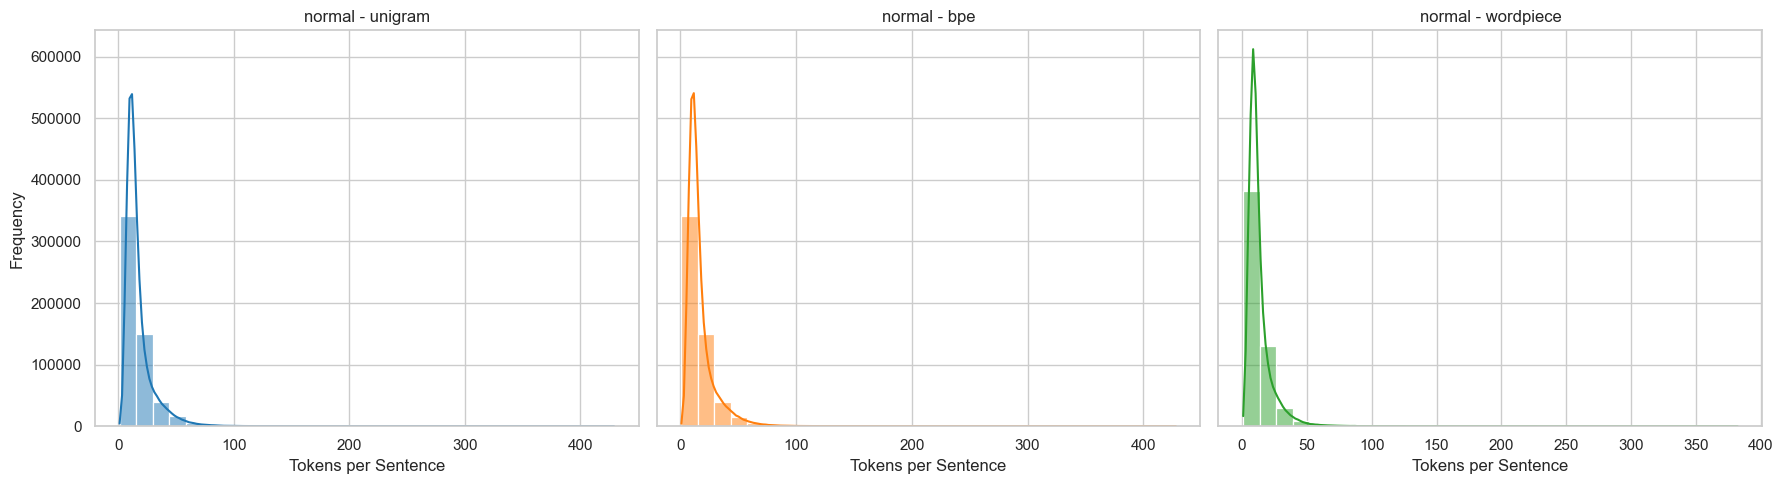

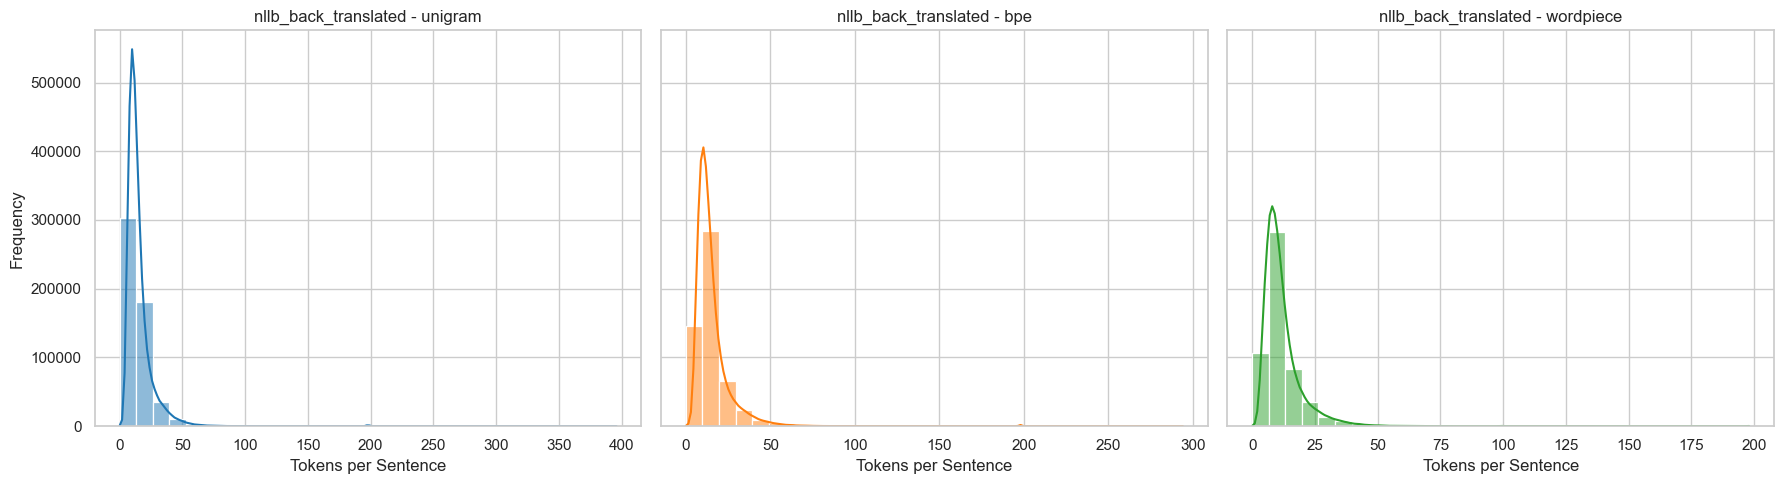

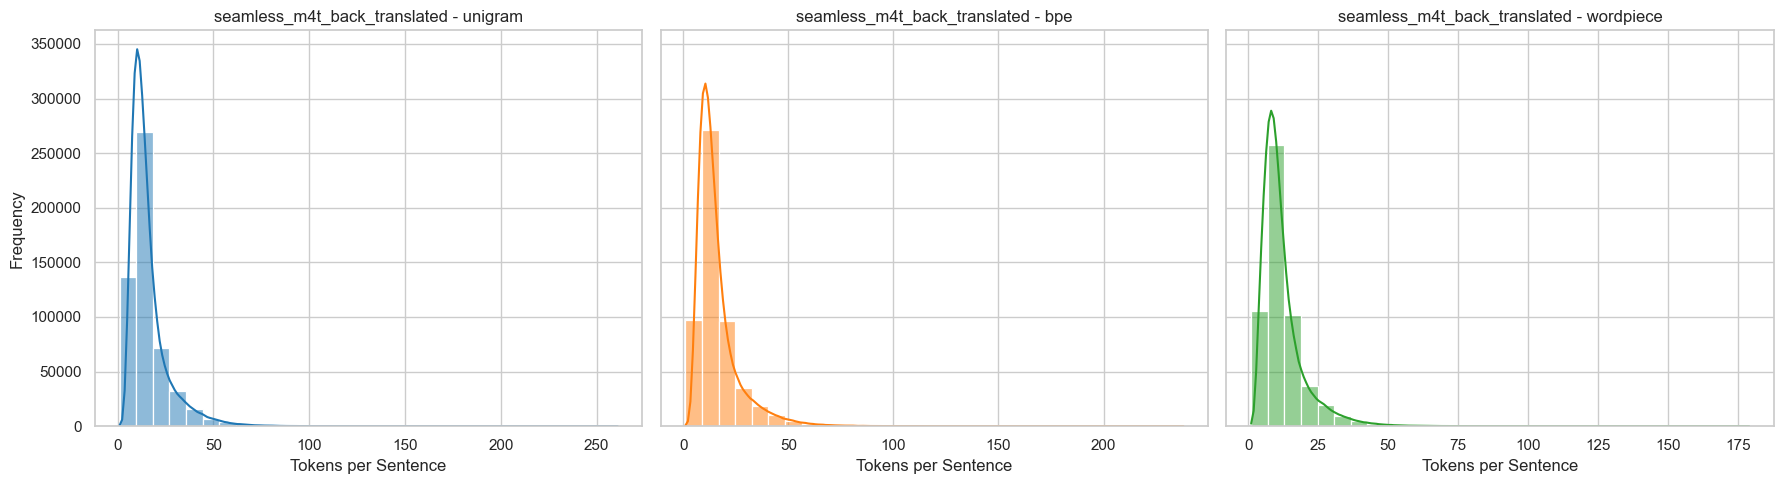

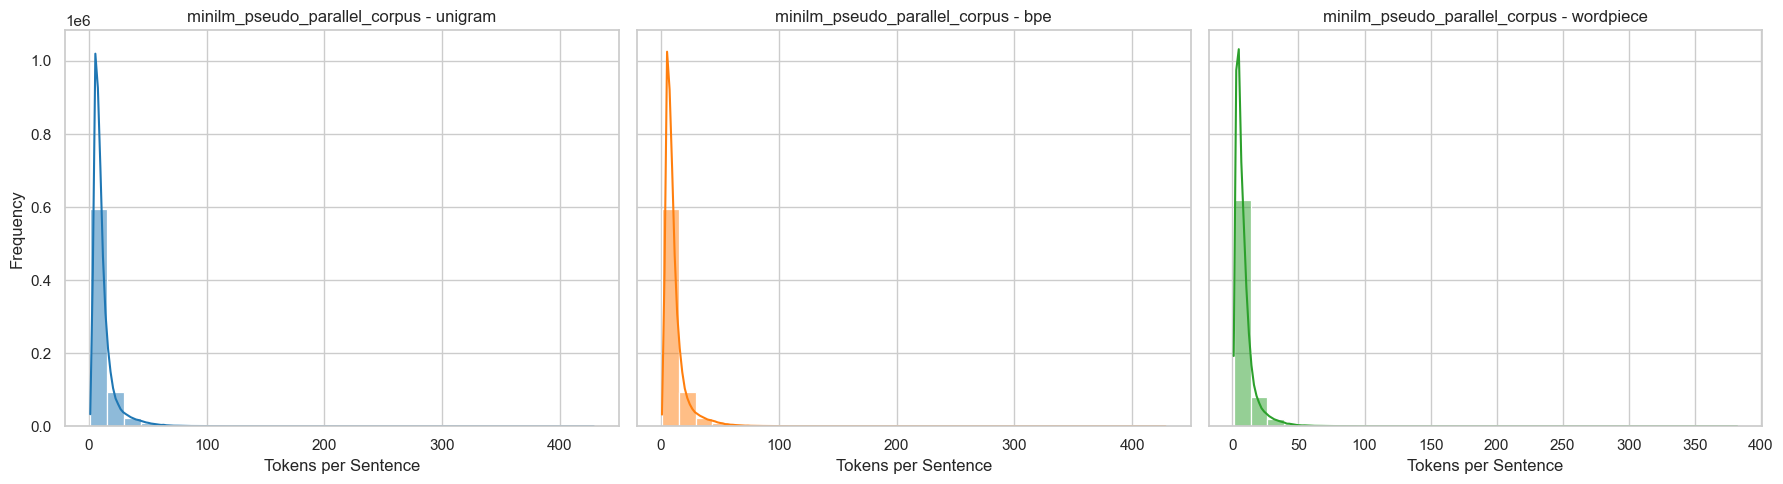

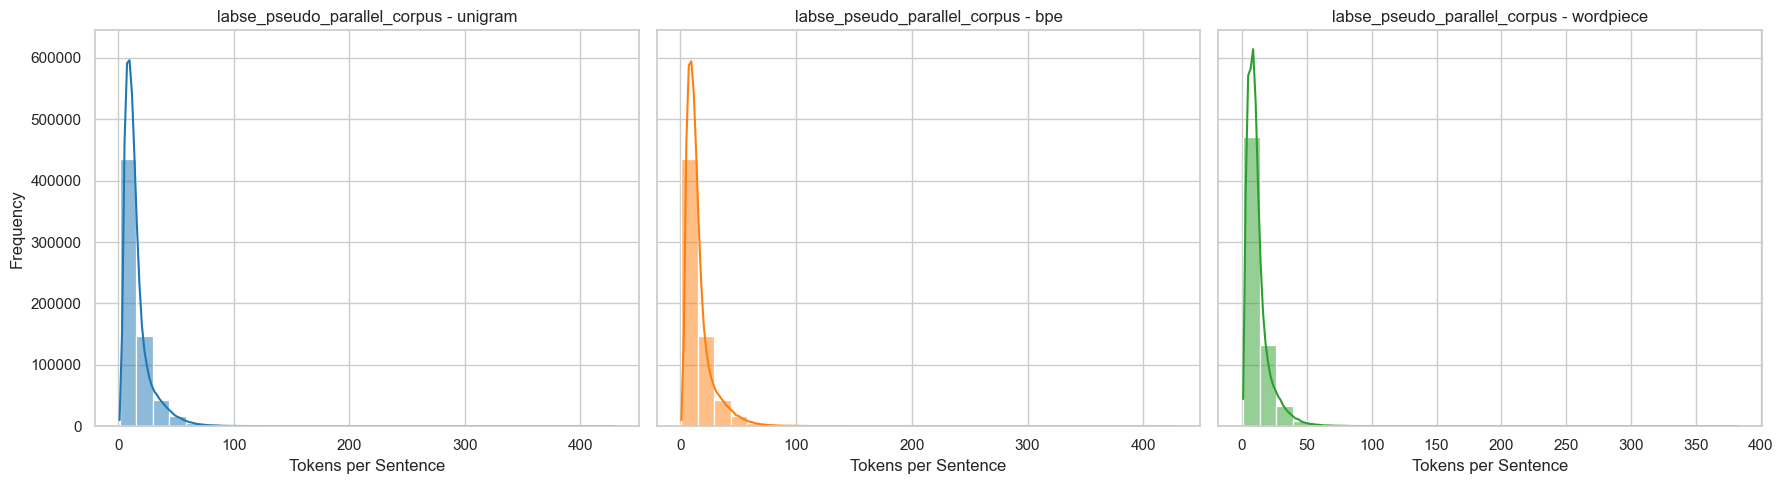

In [114]:
# Token Length Distribution: Separate Plots for Each Tokenization Method
for dataset_name, files in datasets.items():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # Create separate subplots for BPE, WordPiece, Unigram

    for i, method in enumerate(spt_tokenization_methods):
        all_lengths = []
        for file in files:
            df = load_spt_df(f"tokenized_{method}_{file}")
            for column in english_columns:
                if f"{column}_tokens" in df.columns:
                    all_lengths.extend(df[f"{column}_tokens"].apply(lambda x: len(eval(x))))  # Convert string list to actual list

        # Plot each method separately
        sns.histplot(all_lengths, bins=30, kde=True, ax=axes[i], color=sns.color_palette("tab10")[i])
        axes[i].set_title(f"{dataset_name} - {method}")
        axes[i].set_xlabel("Tokens per Sentence")
        axes[i].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

### Vocabulary Similarity

In [117]:
def get_vocabulary(file_list, method):
    vocab = set()
    for file in file_list:
        df = load_spt_df(f"tokenized_{method}_{file}")
        for column in english_columns:
            if f"{column}_tokens" in df.columns:
                for tokens in df[f"{column}_tokens"]:
                    vocab.update(eval(tokens))
    return vocab

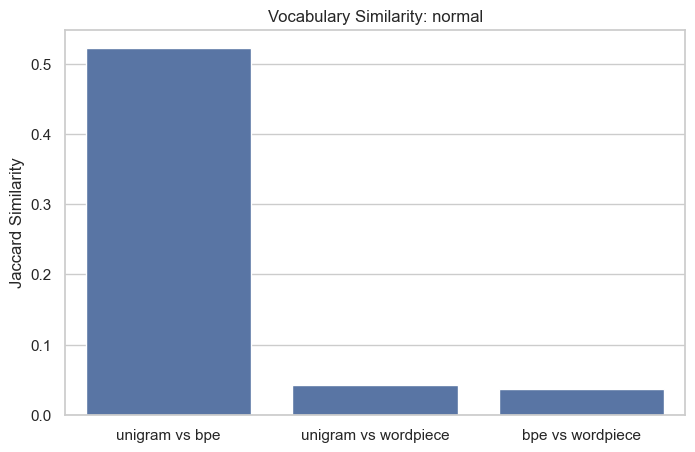

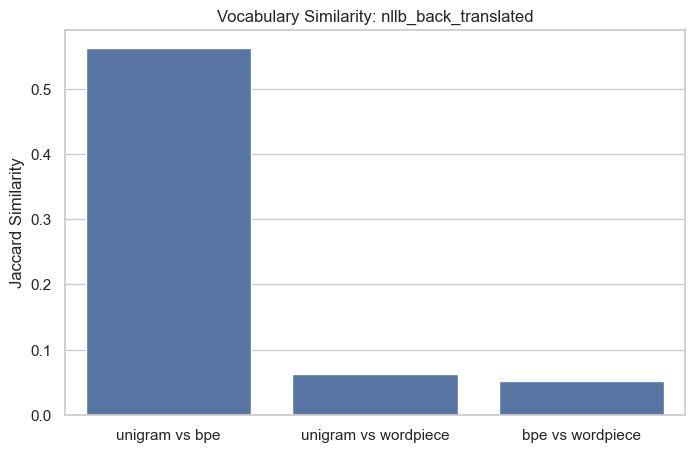

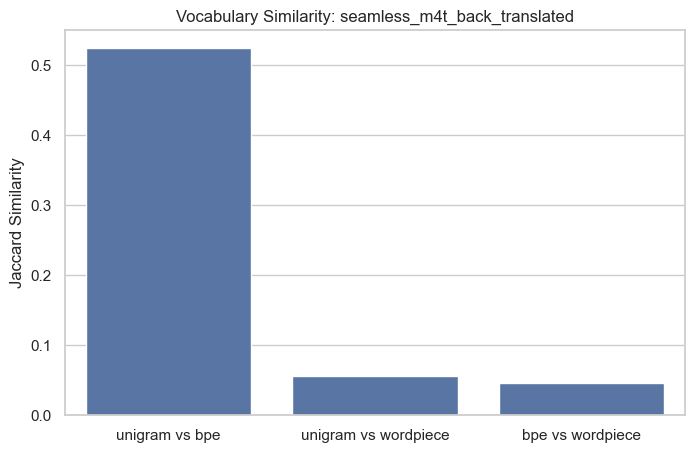

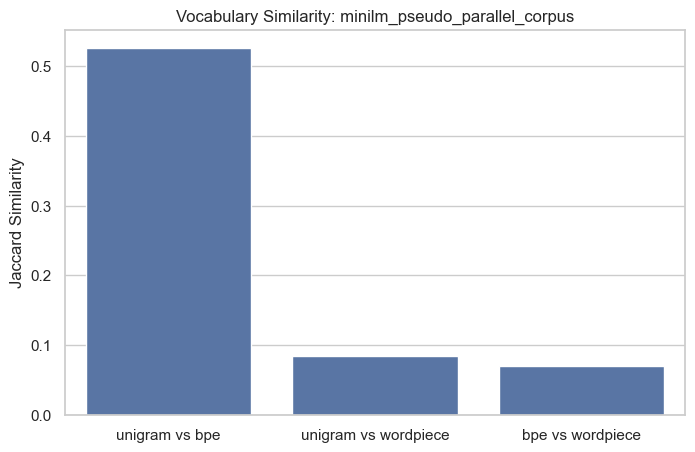

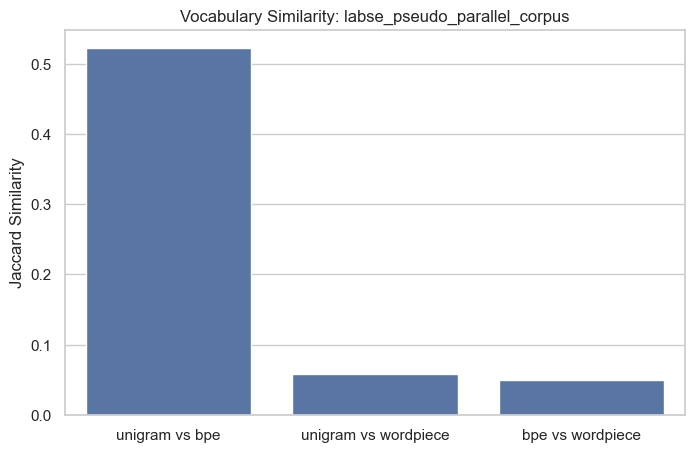

In [ ]:
for dataset_name, files in datasets.items():
    vocabularies = {method: get_vocabulary(files, method) for method in spt_tokenization_methods}
    
    jaccard_scores = []
    method_pairs = []
    for (method1, vocab1), (method2, vocab2) in combinations(vocabularies.items(), 2):
        jaccard = len(vocab1 & vocab2) / len(vocab1 | vocab2)
        jaccard_scores.append(jaccard)
        method_pairs.append(f"{method1} vs {method2}")

    plt.figure(figsize=(8, 5))
    sns.barplot(x=method_pairs, y=jaccard_scores)
    plt.ylabel("Jaccard Similarity")
    plt.title(f"Vocabulary Similarity: {dataset_name}")
    plt.show()


### Subword Fragmentation Analysis

In [135]:
def compute_spt_subword_length(file_list, method):
    subword_lengths = []
    for file in file_list:
        df = load_spt_df(f"tokenized_{method}_{file}")
        for column in english_columns:
            if f"{column}_tokens" in df.columns:
                for tokens in df[f"{column}_tokens"]:
                    subword_lengths.extend([len(token) for token in eval(tokens)])
    return sum(subword_lengths) / len(subword_lengths) if len(subword_lengths) > 0 else 0

In [ ]:
spt_subword_data = []
for dataset_name, files in datasets.items():
    for method in spt_tokenization_methods:
        avg_length = compute_spt_subword_length(files, method)
        spt_subword_data.append({"Dataset": dataset_name, "Method": method, "Avg Subword Length": avg_length})

df_subword = pd.DataFrame(spt_subword_data)

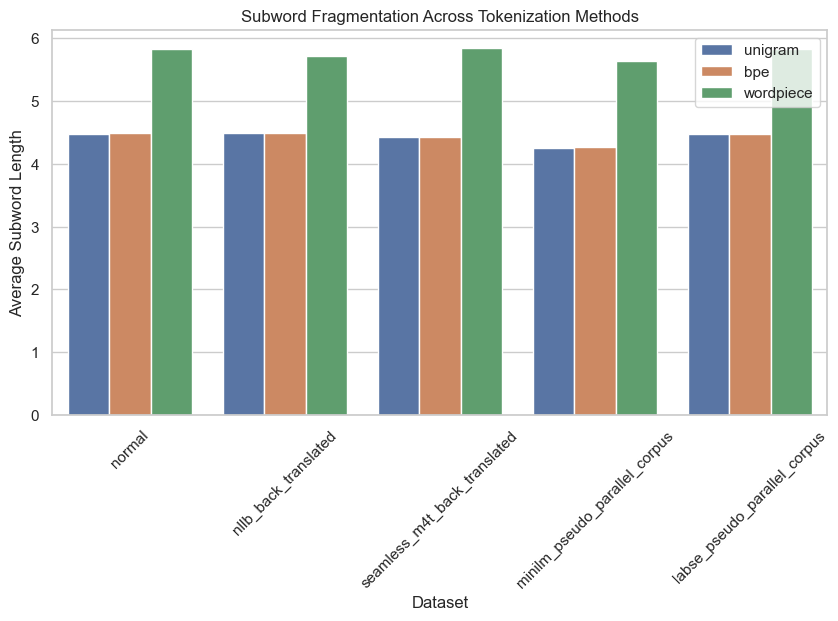

In [140]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Dataset", y="Avg Subword Length", hue="Method", data=df_subword)
plt.xticks(rotation=45)
plt.ylabel("Average Subword Length")
plt.title("Subword Fragmentation Across Tokenization Methods")
plt.legend()
plt.show()

### Rare Token Analysis

In [147]:
def count_spt_rare_tokens(file_list, method, threshold=5):
    token_counts = Counter()
    for file in file_list:
        df = load_spt_df(f"tokenized_{method}_{file}")
        for column in english_columns:
            if f"{column}_tokens" in df.columns:
                for tokens in df[f"{column}_tokens"]:
                    token_counts.update(eval(tokens))

    rare_tokens = [token for token, count in token_counts.items() if count < threshold]
    return len(rare_tokens)

In [149]:
spt_rare_data = []
for dataset_name, files in datasets.items():
    for method in spt_tokenization_methods:
        rare_count = count_spt_rare_tokens(files, method)
        spt_rare_data.append({"Dataset": dataset_name, "Method": method, "Rare Tokens": rare_count})

df_rare = pd.DataFrame(spt_rare_data)

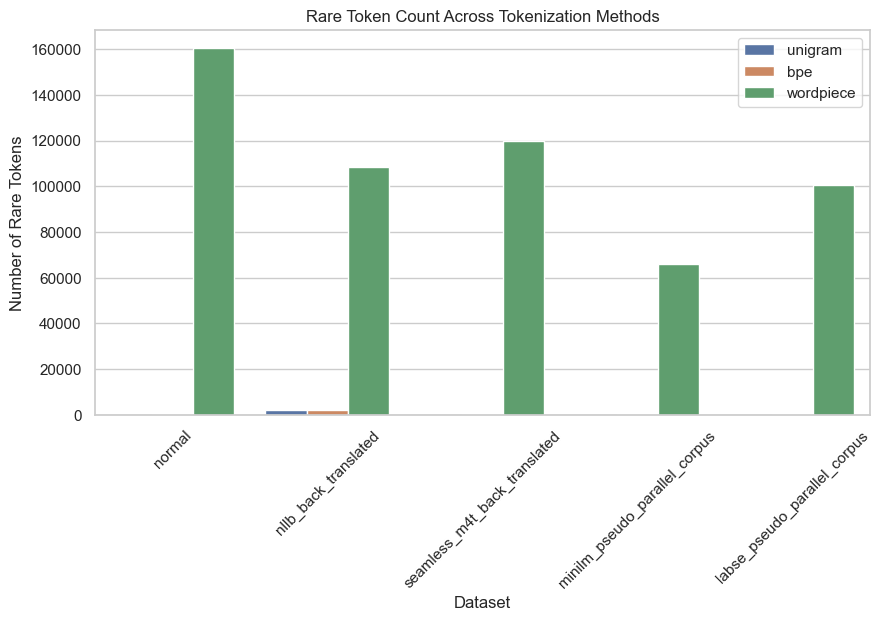

In [150]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Dataset", y="Rare Tokens", hue="Method", data=df_rare)
plt.xticks(rotation=45)
plt.ylabel("Number of Rare Tokens")
plt.title("Rare Token Count Across Tokenization Methods")
plt.legend()
plt.show()

### Overlap Analysis Between Back-Translated and Pseudo-Parallel Corpus

In [154]:
spt_overlap_ratios = {}

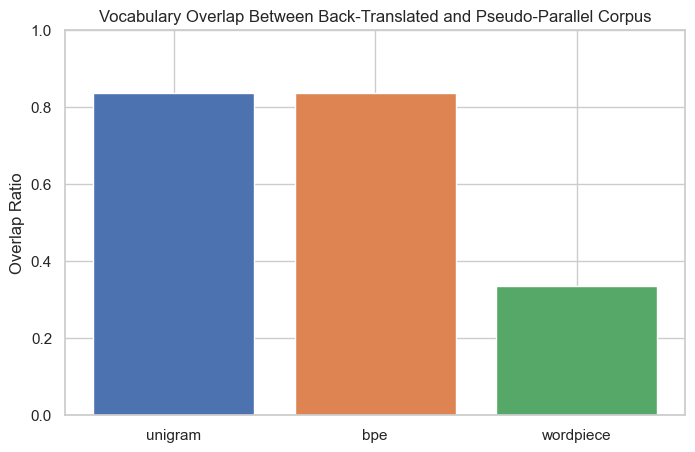

In [155]:
plt.figure(figsize=(8, 5))

for method in spt_tokenization_methods:
    # Compute vocabulary for Back-Translated and Pseudo-Parallel datasets
    bt_vocab = get_vocabulary(datasets["nllb_back_translated"], method) | get_vocabulary(datasets["seamless_m4t_back_translated"], method)
    pp_vocab = get_vocabulary(datasets["minilm_pseudo_parallel_corpus"], method) | get_vocabulary(datasets["labse_pseudo_parallel_corpus"], method)

    # Compute vocabulary overlap ratio
    overlap_ratio = len(bt_vocab & pp_vocab) / len(bt_vocab | pp_vocab)
    spt_overlap_ratios[method] = overlap_ratio

    # Plot each method's overlap ratio
    plt.bar(method, overlap_ratio, label=method)

plt.ylabel("Overlap Ratio")
plt.title("Vocabulary Overlap Between Back-Translated and Pseudo-Parallel Corpus")
plt.ylim(0, 1)
plt.show()

In [156]:
# Print results
for method, ratio in spt_overlap_ratios.items():
    print(f"Vocabulary Overlap Ratio ({method}): {ratio:.4f}")

Vocabulary Overlap Ratio (unigram): 0.8358
Vocabulary Overlap Ratio (bpe): 0.8367
Vocabulary Overlap Ratio (wordpiece): 0.3344
